# Advanced Lane Finding Project


## Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.


In the two blocks below I computed the camera calibration matrix and distortion coefficients. I first use cv2.findChessboardCorners to find image points and generate object points. I then use cv2.calibrateCamera to compute the camera calibration matrix and distortion coefficients.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
from scipy import signal

%matplotlib inline

In [2]:
nx = 9
ny = 6

images = glob.glob("camera_cal/calibration*.jpg")

objpoints = []
imgpoints = []

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

imgs = []

for fname in images:
    img = cv2.imread(fname)
    imgs.append(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        
img_size = (imgs[0].shape[1], imgs[0].shape[0])

# Calibrate camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Save calibration matrix and distortion coefficients
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("camera_calibration_result.p", "wb"))

## Apply a distortion correction to raw images.

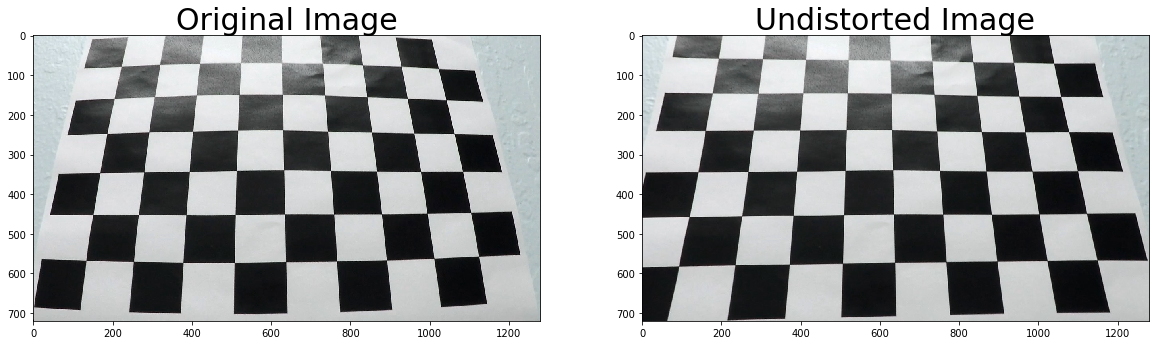

In [3]:
img = cv2.imread('camera_cal/calibration3.jpg')

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('calibration_wide/test_undist.jpg',dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)2

The two images above demonstrate how the distortion in the original image is corrected.

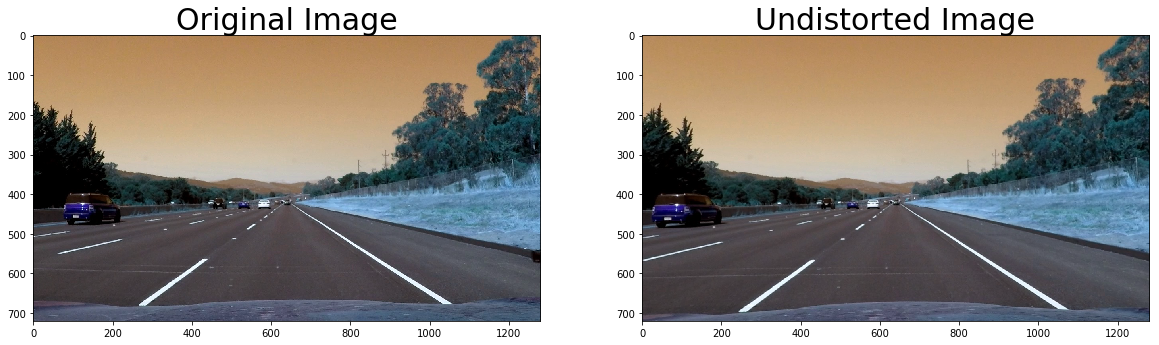

In [4]:
raw = cv2.imread("test_images/straight_lines2.jpg")
imshape = raw.shape

image = cv2.undistort(raw, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(raw)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(image)
ax2.set_title('Undistorted Image', fontsize=30)

## Use color transforms, gradients, etc., to create a thresholded binary image.

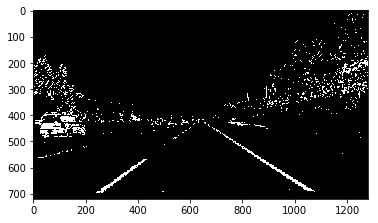

In [5]:
def apply_threshold_v2(image, xgrad_thresh=(20,100), s_thresh=(170,255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= xgrad_thresh[0]) & (scaled_sobel <= xgrad_thresh[1])] = 1

    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

xgrad_thresh_temp = (40,100)
s_thresh_temp=(150,255)

combined_binary = apply_threshold_v2(image, xgrad_thresh=xgrad_thresh_temp, s_thresh=s_thresh_temp)
plt.imshow(combined_binary, cmap="gray")

The image above shows a thresholded image. I use a combination of thresholding x gradient on grayscaled image and thresholding S channel in color image. I combine the two binary thresholds to generate a binary image.

## Apply a perspective transform to rectify binary image ("birds-eye view").

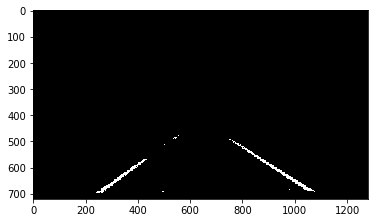

In [6]:
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)

    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    cv2.fillPoly(mask, vertices, ignore_mask_color)

    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


vertices = np.array([[(0,imshape[0]),(550, 470), (700, 470), (imshape[1],imshape[0])]], dtype=np.int32)
masked_image = region_of_interest(combined_binary, vertices)
plt.imshow(masked_image, cmap="gray")

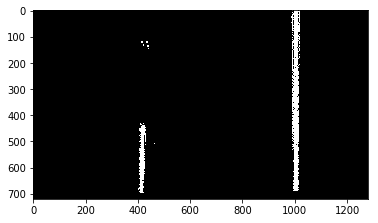

In [7]:
src = np.float32(
    [[200, 720],
     [510, 500],
     [765, 500],
     [1100, 720]])

dst = np.float32(
    [[400,720],
     [400,0],
     [1000,0],
     [1000,720]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

warped = cv2.warpPerspective(combined_binary, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
plt.imshow(warped, cmap="gray")

The code above and the image following demonstrate how I did my perspective transform and the result of the transform. I assumed that the road is on a plane and the plane does not change throughout the video. I selected four points on the original image, two on the left line and two on the right line and I then map the four points to two straight lines. I use cv2.getPerspectiveTransform to calculate the matrix.

## Detect lane pixels and fit to find the lane boundary.

Left coeffs: [ -1.59548390e-04   1.48929110e-01   3.83561816e+02]
righty[0]: , 419.0 , rightx[0]:  989
Right coeffs:  [  2.60912380e-05  -1.79619055e-02   1.00603923e+03]


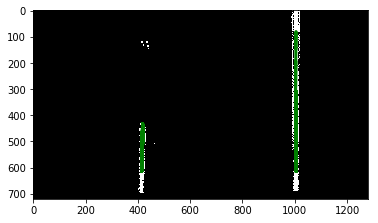

In [8]:
horizontal_offset = 40

def histogram_pixels(warped_thresholded_image, offset=50, steps=6,
                     window_radius=200, medianfilt_kernel_size=51,
                     horizontal_offset=50):
    left_x = []
    left_y = []
    right_x = []
    right_y = []

    height = warped_thresholded_image.shape[0]
    offset_height = height - offset
    width = warped_thresholded_image.shape[1]
    half_frame = warped_thresholded_image.shape[1] // 2
    pixels_per_step = offset_height / steps

    for step in range(steps):
        left_x_window_centres = []
        right_x_window_centres = []
        y_window_centres = []

        window_start_y = height - (step * pixels_per_step) + offset
        window_end_y = window_start_y - pixels_per_step + offset

        histogram = np.sum(warped_thresholded_image[int(window_end_y):int(window_start_y), int(horizontal_offset):int(width - horizontal_offset)], axis=0)

        histogram_smooth = signal.medfilt(histogram, medianfilt_kernel_size)

        left_peaks = np.array(signal.find_peaks_cwt(histogram_smooth[:half_frame], np.arange(1, 10)))
        right_peaks = np.array(signal.find_peaks_cwt(histogram_smooth[half_frame:], np.arange(1, 10)))
        if len(left_peaks) > 0:
            left_peak = max(left_peaks)
            left_x_window_centres.append(left_peak)

        if len(right_peaks) > 0:
            right_peak = max(right_peaks) + half_frame
            right_x_window_centres.append(right_peak)


        if len(left_peaks) > 0 or len(right_peaks) > 0:
            y_window_centres.append((window_start_y + window_end_y) // 2)

        for left_x_centre, y_centre in zip(left_x_window_centres, y_window_centres):
            left_x_additional, left_y_additional = get_pixel_in_window(warped_thresholded_image, left_x_centre,
                                                                       y_centre, window_radius)
            left_x.append(left_x_additional)
            left_y.append(left_y_additional)

        for right_x_centre, y_centre in zip(right_x_window_centres, y_window_centres):
            right_x_additional, right_y_additional = get_pixel_in_window(warped_thresholded_image, right_x_centre,
                                                                         y_centre, window_radius)
            right_x.append(right_x_additional)
            right_y.append(right_y_additional)

    if len(right_x) == 0 or len(left_x) == 0:
        print("Init no peaks for left or right")
        print("left_x: ", left_x)
        print("right_x: ", right_x)

        horizontal_offset = 0

        left_x = []
        left_y = []
        right_x = []
        right_y = []

        for step in range(steps):
            left_x_window_centres = []
            right_x_window_centres = []
            y_window_centres = []

            window_start_y = height - (step * pixels_per_step) + offset
            window_end_y = window_start_y - pixels_per_step + offset

            histogram = np.sum(warped_thresholded_image[int(window_end_y):int(window_start_y),
                               int(horizontal_offset):int(width - horizontal_offset)], axis=0)

            histogram_smooth = signal.medfilt(histogram, medianfilt_kernel_size)

            left_peaks = np.array(signal.find_peaks_cwt(histogram_smooth[:half_frame], np.arange(1, 10)))
            right_peaks = np.array(signal.find_peaks_cwt(histogram_smooth[half_frame:], np.arange(1, 10)))
            if len(left_peaks) > 0:
                left_peak = max(left_peaks)
                left_x_window_centres.append(left_peak)

            if len(right_peaks) > 0:
                right_peak = max(right_peaks) + half_frame
                right_x_window_centres.append(right_peak)

            if len(left_peaks) > 0 or len(right_peaks) > 0:
                y_window_centres.append((window_start_y + window_end_y) // 2)

            for left_x_centre, y_centre in zip(left_x_window_centres, y_window_centres):
                left_x_additional, left_y_additional = get_pixel_in_window(warped_thresholded_image, left_x_centre,
                                                                           y_centre, window_radius)
                left_x.append(left_x_additional)
                left_y.append(left_y_additional)

            for right_x_centre, y_centre in zip(right_x_window_centres, y_window_centres):
                right_x_additional, right_y_additional = get_pixel_in_window(warped_thresholded_image, right_x_centre,
                                                                             y_centre, window_radius)
                right_x.append(right_x_additional)
                right_y.append(right_y_additional)

    return collapse_into_single_arrays(left_x, left_y, right_x, right_y)


def get_pixel_in_window(img, x_center, y_center, size):
    half_size = size // 2
    window = img[int(y_center - half_size):int(y_center + half_size), int(x_center - half_size):int(x_center + half_size)]

    x, y = (window.T == 1).nonzero()

    x = x + x_center - half_size
    y = y + y_center - half_size

    return x, y

def collapse_into_single_arrays(leftx, lefty, rightx, righty):
    leftx = [x
             for array in leftx
             for x in array]
    lefty = [x
             for array in lefty
             for x in array]
    rightx = [x
              for array in rightx
              for x in array]
    righty = [x
              for array in righty
              for x in array]

    leftx = np.array(leftx)
    lefty = np.array(lefty)
    rightx = np.array(rightx)
    righty = np.array(righty)

    return leftx, lefty, rightx, righty

def fit_second_order_poly(indep, dep, return_coeffs=False):
    fit = np.polyfit(indep, dep, 2)
    fitdep = fit[0]*indep**2 + fit[1]*indep + fit[2]
    if return_coeffs == True:
        return fitdep, fit
    else:
        return fitdep
    
leftx, lefty, rightx, righty = histogram_pixels(warped, horizontal_offset=horizontal_offset)

left_fit, left_coeffs = fit_second_order_poly(lefty, leftx, return_coeffs=True)
print("Left coeffs:", left_coeffs)
print("righty[0]: ,", righty[0], ", rightx[0]: ", rightx[0])
right_fit, right_coeffs = fit_second_order_poly(righty, rightx, return_coeffs=True)
print("Right coeffs: ", right_coeffs)

# Plot data

plt.plot(left_fit, lefty, color='green', linewidth=3)
plt.plot(right_fit, righty, color='green', linewidth=3)
plt.imshow(warped, cmap="gray")

I use the following steps to identify lane-line pixels and fit their positions with a polynomial. I first divide the image into horizontal strips. For each step I count all the pixels for each strip using a histogram generated from np.sum. I then smoothen the histogram and find peaks in the left and right halves. I then get the pixels close to the two peak x coordinates.

Left coeffs:  [ -1.59548390e-04   1.48929110e-01   3.83561816e+02]
Right fit:  [  2.60912380e-05  -1.79619055e-02   1.00603923e+03]


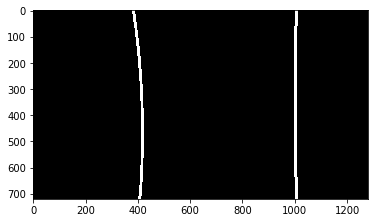

In [9]:

def draw_poly(img, poly, poly_coeffs, steps, color=[255, 0, 0], thickness=10, dashed=False):
    img_height = img.shape[0]
    pixels_per_step = img_height // steps

    for i in range(steps):
        start = i * pixels_per_step
        end = start + pixels_per_step

        start_point = (int(poly(start, poly_coeffs=poly_coeffs)), start)
        end_point = (int(poly(end, poly_coeffs=poly_coeffs)), end)

        if dashed == False or i % 2 == 1:
            img = cv2.line(img, end_point, start_point, color, thickness)

    return img

blank_canvas = np.zeros((720, 1280))


def lane_poly(yval, poly_coeffs):
    return poly_coeffs[0]*yval**2 + poly_coeffs[1]*yval + poly_coeffs[2]


print("Left coeffs: ", left_coeffs)
print("Right fit: ", right_coeffs)
polyfit_left = draw_poly(blank_canvas, lane_poly, left_coeffs, 30)
polyfit_drawn = draw_poly(polyfit_left, lane_poly, right_coeffs, 30)
plt.imshow(polyfit_drawn, cmap="gray")

Left coeffs:  [ -1.59548390e-04   1.48929110e-01   3.83561816e+02]
Right fit:  [  2.60912380e-05  -1.79619055e-02   1.00603923e+03]


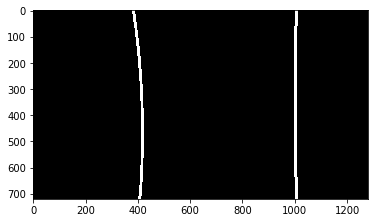

In [10]:
print("Left coeffs: ", left_coeffs)
print("Right fit: ", right_coeffs)
polyfit_left = draw_poly(blank_canvas, lane_poly, left_coeffs, 30)
polyfit_drawn = draw_poly(polyfit_left, lane_poly, right_coeffs, 30)
plt.imshow(polyfit_drawn, cmap="gray")

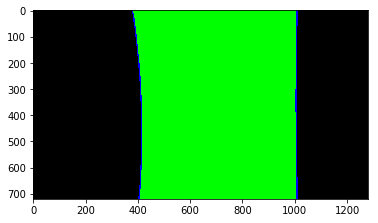

In [11]:
color_canvas = cv2.cvtColor(blank_canvas.astype(np.uint8), cv2.COLOR_GRAY2RGB)

def highlight_lane_line_area(mask_template, left_poly, right_poly, start_y=0, end_y =720):
    area_mask = mask_template
    for y in range(start_y, end_y):
        left = evaluate_poly(y, left_poly)
        right = evaluate_poly(y, right_poly)
        area_mask[y][int(left):int(right)] = 1

    return area_mask

def evaluate_poly(indep, poly_coeffs):
    return poly_coeffs[0]*indep**2 + poly_coeffs[1]*indep + poly_coeffs[2]

trace = color_canvas
trace[polyfit_drawn > 1] = [0,0,255]
area = highlight_lane_line_area(blank_canvas, left_coeffs, right_coeffs)
trace[area == 1] = [0,255,0]
plt.imshow(trace)

## Determine the curvature of the lane and vehicle position with respect to center.

In [12]:
def center(y, left_poly, right_poly):
    center = (1.5 * evaluate_poly(y, left_poly)
              - evaluate_poly(y, right_poly)) / 2
    return center

y_eval = 500
left_curverad = np.absolute(((1 + (2 * left_coeffs[0] * y_eval + left_coeffs[1])**2) ** 1.5) \
                /(2 * left_coeffs[0]))
right_curverad = np.absolute(((1 + (2 * right_coeffs[0] * y_eval + right_coeffs[1]) ** 2) ** 1.5) \
                 /(2 * right_coeffs[0]))
print("Left lane curve radius: ", left_curverad, "pixels")
print("Right lane curve radius: ", right_curverad, "pixels")
curvature = (left_curverad + right_curverad) / 2
centre = center(719, left_coeffs, right_coeffs)
min_curvature = min(left_curverad, right_curverad)

Left lane curve radius:  3134.37560023 pixels
Right lane curve radius:  19165.4211523 pixels


The above block shows the code that I used to calculate the radius of curvature of the lane and the position of the vehicle with respect to center.

## Warp the detected lane boundaries back onto the original image.

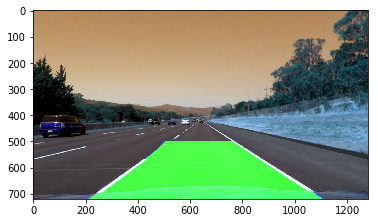

In [13]:
lane_lines = cv2.warpPerspective(trace, Minv, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)

combined_img = cv2.add(lane_lines, image)
plt.imshow(combined_img)

The image above is an example image of my result plotted back down onto the road, showing that the lane area is identified clearly.

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

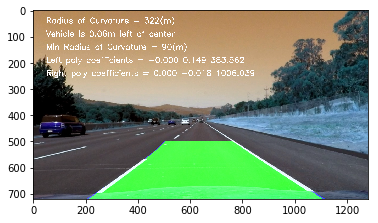

In [14]:
def add_figures_to_image(img, curvature, vehicle_position, min_curvature, left_coeffs=(0,0,0), right_coeffs=(0,0,0)):
    vehicle_position = vehicle_position / 12800 * 3.7
    curvature = curvature / 128 * 3.7
    min_curvature = min_curvature / 128 * 3.7

    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, 'Radius of Curvature = %d(m)' % curvature, (50, 50), font, 1, (255, 255, 255), 2)
    left_or_right = "left" if vehicle_position < 0 else "right"
    cv2.putText(img, 'Vehicle is %.2fm %s of center' % (np.abs(vehicle_position), left_or_right), (50, 100), font, 1,
                (255, 255, 255), 2)
    cv2.putText(img, 'Min Radius of Curvature = %d(m)' % min_curvature, (50, 150), font, 1, (255, 255, 255), 2)
    cv2.putText(img, 'Left poly coefficients = %.3f %.3f %.3f' % (left_coeffs[0], left_coeffs[1], left_coeffs[2]), (50, 200), font, 1, (255, 255, 255), 2)
    cv2.putText(img, 'Right poly coefficients = %.3f %.3f %.3f' % (right_coeffs[0], right_coeffs[1], right_coeffs[2]), (50, 250), font, 1, (255, 255, 255), 2)



add_figures_to_image(combined_img, curvature=curvature, 
                     vehicle_position=centre, 
                     min_curvature=min_curvature,
                     left_coeffs=left_coeffs,
                     right_coeffs=right_coeffs)
plt.imshow(combined_img)

In [28]:
def image_pipeline(raw):
    global prev_left_coeffs
    global prev_right_coeffs
    
    imshape = raw.shape
    image = cv2.undistort(raw, mtx, dist, None, mtx)
    
    xgrad_thresh_temp = (40,100)
    s_thresh_temp=(150,255)

    have_fit = False
    while have_fit == False:
        combined_binary = apply_threshold_v2(image, xgrad_thresh=xgrad_thresh_temp, s_thresh=s_thresh_temp)

        warped = cv2.warpPerspective(combined_binary, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)

        vertices = np.array([[(0,imshape[0]),(550, 470), (700, 470), (imshape[1],imshape[0])]], dtype=np.int32)
        masked_image = region_of_interest(combined_binary, vertices)

        leftx, lefty, rightx, righty = histogram_pixels(warped, horizontal_offset=horizontal_offset)
        
        if len(leftx) > 1 and len(rightx) > 1:
            have_fit = True
        xgrad_thresh_temp = (xgrad_thresh_temp[0] - 2, xgrad_thresh_temp[1] + 2)
        s_thresh_temp = (s_thresh_temp[0] - 2, s_thresh_temp[1] + 2)

    left_fit, left_coeffs = fit_second_order_poly(lefty, leftx, return_coeffs=True)
    right_fit, right_coeffs = fit_second_order_poly(righty, rightx, return_coeffs=True)


    y_eval = 500
    left_curverad = np.absolute(((1 + (2 * left_coeffs[0] * y_eval + left_coeffs[1])**2) ** 1.5) \
                /(2 * left_coeffs[0]))
    right_curverad = np.absolute(((1 + (2 * right_coeffs[0] * y_eval + right_coeffs[1]) ** 2) ** 1.5) \
                 /(2 * right_coeffs[0]))

    curvature = (left_curverad + right_curverad) / 2
    centre = center(719, left_coeffs, right_coeffs)
    min_curvature = min(left_curverad, right_curverad)

    blank_canvas = np.zeros((720, 1280))
    polyfit_left = draw_poly(blank_canvas, lane_poly, left_coeffs, 30)
    polyfit_drawn = draw_poly(polyfit_left, lane_poly, right_coeffs, 30)
    
    trace = cv2.cvtColor(blank_canvas.astype(np.uint8), cv2.COLOR_GRAY2RGB)
    trace[polyfit_drawn > 1] = [0,0,255]
    area = highlight_lane_line_area(blank_canvas, left_coeffs, right_coeffs)
    trace[area == 1] = [0,255,0]
    
    lane_lines = cv2.warpPerspective(trace, Minv, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)

    combined_img = cv2.add(lane_lines, image)
    
    y_eval = 500
    left_curverad = np.absolute(((1 + (2 * left_coeffs[0] * y_eval + left_coeffs[1])**2) ** 1.5) \
                /(2 * left_coeffs[0]))
    right_curverad = np.absolute(((1 + (2 * right_coeffs[0] * y_eval + right_coeffs[1]) ** 2) ** 1.5) \
                 /(2 * right_coeffs[0]))
    curvature = (left_curverad + right_curverad) / 2
    centre = center(719, left_coeffs, right_coeffs)
    min_curvature = min(left_curverad, right_curverad)
    
    add_figures_to_image(combined_img, curvature=curvature, 
                     vehicle_position=centre, 
                     min_curvature=min_curvature,
                     left_coeffs=left_coeffs,
                     right_coeffs=right_coeffs)


    return combined_img

In [29]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'project_output_color.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(image_pipeline)
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_output_color.mp4
[MoviePy] Writing video project_output_color.mp4


  2%|▏         | 19/1261 [00:06<06:43,  3.08it/s]

Init no peaks for left or right
left_x:  [array([432, 432, 448, ..., 490, 499, 499]), array([314, 314, 314, ..., 488, 488, 489]), array([446, 446, 446, ..., 477, 477, 477]), array([444, 444, 444, ..., 476, 476, 476]), array([384, 384, 384, ..., 492, 492, 492])]
right_x:  []
Init no peaks for left or right
left_x:  [array([432, 432, 448, ..., 490, 499, 499]), array([432, 432, 448, ..., 488, 488, 489]), array([446, 446, 446, ..., 477, 477, 477]), array([444, 444, 444, ..., 476, 476, 476]), array([384, 384, 384, ..., 492, 492, 492])]
right_x:  []
Init no peaks for left or right
left_x:  [array([421, 432, 432, ..., 500, 501, 502]), array([432, 432, 447, ..., 488, 488, 489]), array([446, 446, 446, ..., 477, 477, 477]), array([444, 444, 444, ..., 476, 476, 476]), array([384, 384, 384, ..., 492, 492, 492])]
right_x:  []
Init no peaks for left or right
left_x:  [array([392, 393, 421, ..., 504, 504, 505]), array([392, 393, 432, ..., 504, 504, 505]), array([446, 446, 446, ..., 477, 477, 477]), a

  3%|▎         | 32/1261 [00:15<07:03,  2.90it/s]

Init no peaks for left or right
left_x:  [array([433, 433, 434, ..., 468, 487, 498]), array([435, 435, 435, ..., 464, 464, 487]), array([436, 436, 436, ..., 467, 467, 467]), array([437, 437, 438, ..., 468, 468, 468]), array([374, 374, 374, ..., 487, 487, 487])]
right_x:  []
Init no peaks for left or right
left_x:  [array([433, 433, 434, ..., 488, 489, 498]), array([435, 435, 435, ..., 488, 488, 489]), array([436, 436, 436, ..., 467, 467, 467]), array([437, 437, 438, ..., 468, 468, 468]), array([374, 374, 374, ..., 487, 487, 487])]
right_x:  []
Init no peaks for left or right
left_x:  [array([433, 433, 434, ..., 489, 498, 499]), array([435, 435, 435, ..., 488, 488, 489]), array([436, 436, 436, ..., 467, 467, 467]), array([437, 437, 437, ..., 468, 468, 468]), array([374, 374, 374, ..., 487, 487, 487])]
right_x:  []
Init no peaks for left or right
left_x:  [array([433, 433, 434, ..., 489, 498, 499]), array([435, 435, 435, ..., 488, 488, 489]), array([436, 436, 436, ..., 467, 467, 467]), a

  5%|▍         | 57/1261 [00:29<06:26,  3.12it/s]

Init no peaks for left or right
left_x:  [array([442, 442, 442, ..., 468, 469, 469]), array([439, 439, 439, ..., 468, 469, 469]), array([435, 435, 435, ..., 468, 468, 468]), array([374, 374, 374, ..., 481, 481, 481])]
right_x:  []
Init no peaks for left or right
left_x:  [array([429, 430, 442, ..., 468, 469, 469]), array([439, 439, 439, ..., 468, 469, 469]), array([435, 435, 435, ..., 468, 468, 468]), array([374, 374, 374, ..., 481, 481, 481])]
right_x:  []
Init no peaks for left or right
left_x:  [array([429, 430, 442, ..., 468, 469, 469]), array([439, 439, 439, ..., 468, 469, 469]), array([435, 435, 435, ..., 468, 468, 468]), array([374, 374, 374, ..., 481, 481, 481])]
right_x:  []
Init no peaks for left or right
left_x:  [array([429, 430, 442, ..., 468, 469, 469]), array([439, 439, 439, ..., 468, 469, 469]), array([434, 434, 435, ..., 468, 468, 468]), array([374, 374, 374, ..., 483, 483, 483])]
right_x:  []
Init no peaks for left or right
left_x:  [array([428, 428, 429, ..., 469, 46

  5%|▌         | 69/1261 [00:39<07:16,  2.73it/s]

Init no peaks for left or right
left_x:  [array([432, 432, 432, ..., 467, 467, 468]), array([432, 432, 432, ..., 467, 467, 468]), array([433, 433, 433, ..., 463, 463, 463]), array([434, 434, 434, ..., 479, 479, 479])]
right_x:  []
Init no peaks for left or right
left_x:  [array([432, 432, 432, ..., 467, 468, 468]), array([432, 432, 432, ..., 467, 468, 468]), array([433, 433, 433, ..., 463, 463, 463]), array([433, 433, 433, ..., 479, 479, 479])]
right_x:  []
Init no peaks for left or right
left_x:  [array([431, 432, 432, ..., 467, 468, 468]), array([432, 432, 432, ..., 467, 468, 468]), array([433, 433, 433, ..., 463, 463, 463]), array([433, 433, 433, ..., 479, 479, 479])]
right_x:  []
Init no peaks for left or right
left_x:  [array([431, 431, 431, ..., 467, 468, 468]), array([432, 432, 432, ..., 467, 468, 468]), array([433, 433, 433, ..., 463, 463, 463]), array([433, 433, 433, ..., 479, 479, 479])]
right_x:  []
Init no peaks for left or right
left_x:  [array([426, 427, 431, ..., 467, 46

  6%|▌         | 70/1261 [00:46<45:43,  2.30s/it]

Init no peaks for left or right
left_x:  [array([431, 431, 431, ..., 467, 467, 467]), array([433, 433, 433, ..., 461, 461, 461]), array([433, 433, 433, ..., 463, 463, 463]), array([380, 380, 380, ..., 479, 479, 479])]
right_x:  []


  7%|▋         | 82/1261 [00:50<06:47,  2.89it/s]

Init no peaks for left or right
left_x:  [array([417, 417, 417, ..., 444, 444, 445]), array([415, 415, 415, ..., 444, 444, 444]), array([412, 412, 412, ..., 444, 444, 444]), array([410, 410, 410, ..., 445, 445, 445])]
right_x:  []
Init no peaks for left or right
left_x:  [array([417, 417, 417, ..., 445, 445, 445]), array([415, 415, 415, ..., 444, 444, 445]), array([412, 412, 412, ..., 445, 445, 445]), array([410, 410, 410, ..., 445, 445, 445])]
right_x:  []
Init no peaks for left or right
left_x:  [array([417, 417, 417, ..., 445, 445, 445]), array([415, 415, 415, ..., 444, 444, 445]), array([412, 412, 412, ..., 446, 446, 446]), array([410, 410, 410, ..., 446, 446, 446])]
right_x:  []
Init no peaks for left or right
left_x:  [array([417, 417, 417, ..., 445, 445, 445]), array([415, 415, 415, ..., 444, 444, 445]), array([412, 412, 412, ..., 446, 446, 446]), array([410, 410, 410, ..., 447, 447, 447])]
right_x:  []
Init no peaks for left or right
left_x:  [array([417, 417, 417, ..., 445, 44

  8%|▊         | 106/1261 [01:04<06:07,  3.14it/s]

Init no peaks for left or right
left_x:  [array([429, 429, 429, ..., 456, 456, 456]), array([429, 429, 430, ..., 458, 458, 458]), array([431, 431, 431, ..., 458, 458, 458]), array([430, 430, 430, ..., 460, 460, 460])]
right_x:  []


  8%|▊         | 107/1261 [01:05<08:49,  2.18it/s]

Init no peaks for left or right
left_x:  [array([429, 429, 429, ..., 455, 456, 499]), array([430, 431, 431, ..., 458, 458, 458]), array([432, 432, 432, ..., 461, 461, 461]), array([433, 433, 433, ..., 461, 461, 461]), array([375, 375, 375, ..., 483, 483, 483])]
right_x:  []
Init no peaks for left or right
left_x:  [array([429, 429, 429, ..., 455, 456, 499]), array([430, 430, 430, ..., 458, 458, 458]), array([432, 432, 432, ..., 461, 461, 461]), array([433, 433, 433, ..., 461, 461, 461]), array([375, 375, 375, ..., 483, 483, 483])]
right_x:  []
Init no peaks for left or right
left_x:  [array([429, 429, 429, ..., 456, 499, 499]), array([430, 430, 430, ..., 458, 458, 458]), array([432, 432, 432, ..., 461, 461, 461]), array([433, 433, 433, ..., 461, 461, 461]), array([375, 375, 375, ..., 483, 483, 483])]
right_x:  []
Init no peaks for left or right
left_x:  [array([428, 429, 429, ..., 456, 499, 499]), array([430, 430, 430, ..., 458, 458, 458]), array([432, 432, 432, ..., 461, 461, 461]), a

 10%|▉         | 120/1261 [01:16<06:45,  2.81it/s]

Init no peaks for left or right
left_x:  [array([336, 337, 437, ..., 467, 467, 499]), array([440, 440, 440, ..., 469, 469, 469]), array([443, 443, 443, ..., 472, 472, 472]), array([444, 444, 444, ..., 474, 474, 474]), array([383, 383, 383, ..., 491, 491, 491])]
right_x:  []
Init no peaks for left or right
left_x:  [array([335, 336, 337, ..., 467, 467, 499]), array([440, 440, 440, ..., 469, 469, 469]), array([443, 443, 443, ..., 472, 472, 472]), array([444, 444, 444, ..., 474, 474, 474]), array([383, 383, 383, ..., 491, 491, 491])]
right_x:  []
Init no peaks for left or right
left_x:  [array([335, 335, 336, ..., 467, 467, 499]), array([440, 440, 440, ..., 469, 469, 469]), array([443, 443, 443, ..., 472, 472, 472]), array([444, 444, 444, ..., 474, 474, 474]), array([383, 383, 383, ..., 491, 491, 491])]
right_x:  []
Init no peaks for left or right
left_x:  [array([335, 335, 336, ..., 467, 467, 499]), array([440, 440, 440, ..., 469, 469, 469]), array([442, 443, 443, ..., 472, 472, 472]), a

 10%|▉         | 121/1261 [01:22<36:33,  1.92s/it]

Init no peaks for left or right
left_x:  [array([438, 438, 438, ..., 468, 468, 468]), array([441, 441, 441, ..., 470, 470, 470]), array([444, 444, 444, ..., 473, 473, 473]), array([446, 446, 446, ..., 478, 478, 478]), array([385, 385, 385, ..., 491, 491, 491])]
right_x:  []
Init no peaks for left or right
left_x:  [array([438, 438, 438, ..., 469, 469, 499]), array([441, 441, 441, ..., 470, 470, 470]), array([444, 444, 444, ..., 473, 474, 474]), array([446, 446, 446, ..., 478, 478, 478]), array([385, 385, 385, ..., 493, 493, 493])]
right_x:  []
Init no peaks for left or right
left_x:  [array([438, 438, 438, ..., 469, 469, 499]), array([441, 441, 441, ..., 470, 471, 471]), array([444, 444, 444, ..., 473, 474, 474]), array([446, 446, 446, ..., 478, 478, 478]), array([385, 385, 385, ..., 493, 493, 493])]
right_x:  []
Init no peaks for left or right
left_x:  [array([438, 438, 438, ..., 469, 469, 499]), array([441, 441, 441, ..., 470, 471, 471]), array([444, 444, 444, ..., 473, 474, 474]), a

 11%|█▏        | 145/1261 [01:35<05:52,  3.17it/s]

Init no peaks for left or right
left_x:  [array([], dtype=int64), array([447, 447, 447, ..., 473, 474, 474]), array([447, 447, 447, ..., 476, 476, 476]), array([388, 388, 389, ..., 491, 491, 491])]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([447, 447, 447, ..., 474, 474, 474]), array([447, 447, 447, ..., 476, 476, 476]), array([388, 388, 389, ..., 493, 493, 493])]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([447, 447, 447, ..., 474, 474, 474]), array([447, 447, 447, ..., 477, 477, 477]), array([388, 388, 389, ..., 493, 493, 493])]
right_x:  []
Init no peaks for left or right
left_x:  [array([446, 446, 446, ..., 476, 477, 477]), array([446, 446, 447, ..., 476, 477, 477]), array([447, 447, 447, ..., 477, 477, 477]), array([388, 388, 389, ..., 493, 493, 493])]
right_x:  []
Init no peaks for left or right
left_x:  [array([446, 446, 446, ..., 478, 478, 478]), array([446, 446, 447, ..., 478, 478, 478]), array(

 13%|█▎        | 170/1261 [01:49<05:45,  3.15it/s]

Init no peaks for left or right
left_x:  [array([377, 429, 429, ..., 456, 456, 456]), array([377, 429, 429, ..., 458, 458, 458]), array([429, 429, 429, ..., 458, 458, 458]), array([427, 427, 427, ..., 458, 458, 458]), array([366, 366, 366, ..., 477, 477, 477])]
right_x:  []
Init no peaks for left or right
left_x:  [array([375, 376, 376, ..., 456, 456, 499]), array([375, 376, 376, ..., 458, 458, 458]), array([429, 429, 429, ..., 458, 458, 458]), array([426, 426, 426, ..., 458, 458, 458]), array([365, 365, 365, ..., 477, 477, 477])]
right_x:  []
Init no peaks for left or right
left_x:  [array([375, 376, 376, ..., 456, 456, 499]), array([375, 376, 376, ..., 458, 458, 458]), array([429, 429, 429, ..., 458, 458, 458]), array([426, 426, 426, ..., 458, 458, 459]), array([365, 365, 365, ..., 477, 477, 477])]
right_x:  []
Init no peaks for left or right
left_x:  [array([375, 376, 376, ..., 464, 499, 499]), array([375, 376, 376, ..., 458, 464, 464]), array([429, 429, 429, ..., 458, 458, 458]), a

 14%|█▍        | 182/1261 [01:58<06:17,  2.86it/s]

Init no peaks for left or right
left_x:  [array([422, 423, 423, ..., 450, 450, 499]), array([424, 424, 424, ..., 450, 450, 450]), array([422, 422, 422, ..., 451, 451, 451]), array([422, 422, 422, ..., 451, 451, 451]), array([364, 364, 365, ..., 477, 477, 477])]
right_x:  []
Init no peaks for left or right
left_x:  [array([422, 423, 423, ..., 464, 464, 499]), array([423, 423, 424, ..., 450, 464, 464]), array([422, 422, 422, ..., 451, 451, 451]), array([422, 422, 422, ..., 451, 451, 451]), array([364, 364, 365, ..., 477, 477, 477])]
right_x:  []
Init no peaks for left or right
left_x:  [array([422, 423, 423, ..., 464, 464, 499]), array([423, 423, 424, ..., 450, 464, 464]), array([422, 422, 422, ..., 451, 451, 451]), array([421, 421, 421, ..., 451, 451, 451]), array([364, 364, 365, ..., 477, 477, 477])]
right_x:  []
Init no peaks for left or right
left_x:  [array([422, 423, 423, ..., 464, 499, 503]), array([423, 423, 423, ..., 450, 464, 464]), array([422, 422, 422, ..., 451, 451, 451]), a

 15%|█▌        | 194/1261 [02:08<06:21,  2.80it/s]

Init no peaks for left or right
left_x:  [array([377, 378, 378, ..., 470, 470, 470]), array([444, 444, 444, ..., 473, 473, 473]), array([445, 445, 445, ..., 475, 475, 475]), array([391, 391, 391, ..., 493, 493, 493])]
right_x:  []
Init no peaks for left or right
left_x:  [array([377, 378, 378, ..., 499, 499, 503]), array([377, 378, 378, ..., 470, 470, 503]), array([444, 444, 444, ..., 473, 473, 473]), array([445, 445, 445, ..., 475, 475, 475]), array([391, 391, 391, ..., 493, 493, 493])]
right_x:  []
Init no peaks for left or right
left_x:  [array([377, 378, 378, ..., 499, 499, 503]), array([377, 378, 378, ..., 470, 470, 503]), array([444, 444, 444, ..., 473, 473, 473]), array([445, 445, 445, ..., 475, 475, 475]), array([391, 391, 391, ..., 493, 493, 493])]
right_x:  []
Init no peaks for left or right
left_x:  [array([377, 378, 378, ..., 499, 500, 503]), array([377, 378, 378, ..., 470, 470, 503]), array([444, 444, 444, ..., 473, 473, 473]), array([445, 445, 445, ..., 475, 475, 475]), a

 17%|█▋        | 219/1261 [02:21<05:37,  3.09it/s]

Init no peaks for left or right
left_x:  [array([375, 376, 378, ..., 450, 450, 498]), array([375, 376, 378, ..., 453, 453, 453]), array([424, 424, 424, ..., 454, 454, 454]), array([421, 421, 421, ..., 454, 454, 454]), array([356, 356, 356, ..., 473, 473, 473])]
right_x:  []
Init no peaks for left or right
left_x:  [array([375, 376, 378, ..., 450, 450, 498]), array([375, 376, 378, ..., 453, 453, 453]), array([424, 424, 424, ..., 454, 454, 454]), array([421, 421, 421, ..., 454, 454, 454]), array([356, 356, 356, ..., 473, 473, 473])]
right_x:  []
Init no peaks for left or right
left_x:  [array([375, 376, 376, ..., 450, 450, 498]), array([375, 376, 376, ..., 453, 453, 453]), array([424, 424, 424, ..., 454, 454, 454]), array([421, 421, 421, ..., 454, 454, 454]), array([356, 356, 356, ..., 473, 473, 473])]
right_x:  []
Init no peaks for left or right
left_x:  [array([375, 376, 376, ..., 498, 503, 503]), array([375, 376, 376, ..., 453, 453, 453]), array([424, 424, 424, ..., 454, 454, 454]), a

 18%|█▊        | 231/1261 [02:31<06:01,  2.85it/s]

Init no peaks for left or right
left_x:  [array([414, 415, 415, ..., 442, 442, 442]), array([414, 414, 414, ..., 442, 443, 443]), array([411, 411, 411, ..., 442, 442, 443]), array([408, 408, 408, ..., 441, 442, 442]), array([344, 344, 344, ..., 459, 459, 459])]
right_x:  []
Init no peaks for left or right
left_x:  [array([414, 415, 415, ..., 442, 442, 442]), array([413, 414, 414, ..., 442, 443, 443]), array([411, 411, 411, ..., 442, 442, 443]), array([408, 408, 408, ..., 442, 442, 442]), array([344, 344, 344, ..., 459, 459, 459])]
right_x:  []
Init no peaks for left or right
left_x:  [array([414, 414, 415, ..., 442, 442, 442]), array([413, 414, 414, ..., 443, 443, 443]), array([411, 411, 411, ..., 443, 443, 443]), array([408, 408, 408, ..., 442, 442, 442]), array([342, 342, 342, ..., 459, 459, 459])]
right_x:  []
Init no peaks for left or right
left_x:  [array([414, 414, 415, ..., 442, 442, 442]), array([413, 414, 414, ..., 443, 443, 443]), array([411, 411, 411, ..., 443, 443, 443]), a

 19%|█▉        | 243/1261 [02:40<05:48,  2.92it/s]

Init no peaks for left or right
left_x:  [array([403, 403, 404, ..., 430, 430, 431]), array([403, 403, 404, ..., 431, 431, 431]), array([403, 404, 404, ..., 433, 433, 433]), array([401, 401, 401, ..., 433, 433, 433]), array([400, 400, 400, ..., 451, 451, 451])]
right_x:  []
Init no peaks for left or right
left_x:  [array([403, 403, 403, ..., 430, 430, 431]), array([403, 403, 403, ..., 431, 431, 431]), array([403, 403, 403, ..., 433, 433, 433]), array([401, 401, 401, ..., 433, 433, 433]), array([400, 400, 400, ..., 451, 451, 451])]
right_x:  []
Init no peaks for left or right
left_x:  [array([403, 403, 403, ..., 430, 430, 431]), array([403, 403, 403, ..., 431, 431, 431]), array([403, 403, 403, ..., 433, 433, 433]), array([401, 401, 401, ..., 433, 433, 433]), array([400, 400, 400, ..., 451, 451, 451])]
right_x:  []
Init no peaks for left or right
left_x:  [array([403, 403, 403, ..., 430, 430, 431]), array([403, 403, 403, ..., 431, 431, 431]), array([403, 403, 403, ..., 433, 433, 433]), a

 19%|█▉        | 244/1261 [02:44<24:32,  1.45s/it]

Init no peaks for left or right
left_x:  [array([402, 403, 403, ..., 430, 430, 431]), array([403, 404, 404, ..., 431, 432, 432]), array([402, 402, 402, ..., 433, 433, 433]), array([342, 342, 343, ..., 449, 449, 449]), array([342, 342, 343, ..., 449, 449, 449])]
right_x:  []
Init no peaks for left or right
left_x:  [array([402, 402, 403, ..., 430, 430, 431]), array([403, 404, 404, ..., 431, 432, 432]), array([402, 402, 402, ..., 433, 433, 433]), array([342, 342, 343, ..., 451, 451, 451]), array([342, 342, 343, ..., 451, 451, 451])]
right_x:  []


 23%|██▎       | 292/1261 [03:00<05:17,  3.05it/s]

Init no peaks for left or right
left_x:  [array([422, 423, 423, ..., 452, 452, 498]), array([424, 425, 426, ..., 457, 457, 457]), array([428, 428, 429, ..., 461, 461, 461]), array([432, 432, 432, ..., 463, 463, 463]), array([376, 376, 377, ..., 483, 483, 483])]
right_x:  []


 24%|██▍       | 304/1261 [03:04<05:04,  3.14it/s]

Init no peaks for left or right
left_x:  [array([375, 376, 421, ..., 449, 449, 449]), array([375, 376, 422, ..., 452, 453, 453]), array([425, 425, 426, ..., 455, 456, 456]), array([427, 427, 427, ..., 457, 457, 457]), array([366, 366, 366, ..., 477, 477, 477])]
right_x:  []


 27%|██▋       | 340/1261 [03:16<04:51,  3.16it/s]

Init no peaks for left or right
left_x:  [array([435, 435, 435, ..., 468, 469, 469]), array([439, 439, 439, ..., 473, 474, 474]), array([444, 444, 444, ..., 481, 481, 481]), array([398, 398, 398, ..., 497, 497, 497])]
right_x:  []
Init no peaks for left or right
left_x:  [array([433, 433, 433, ..., 462, 462, 499]), array([435, 435, 435, ..., 468, 469, 469]), array([439, 439, 439, ..., 473, 474, 474]), array([444, 444, 444, ..., 481, 481, 481]), array([397, 397, 397, ..., 497, 497, 497])]
right_x:  []
Init no peaks for left or right
left_x:  [array([433, 433, 433, ..., 462, 462, 499]), array([435, 435, 435, ..., 468, 469, 469]), array([439, 439, 439, ..., 473, 474, 474]), array([444, 444, 444, ..., 481, 481, 481]), array([397, 397, 397, ..., 499, 499, 499])]
right_x:  []
Init no peaks for left or right
left_x:  [array([433, 433, 433, ..., 462, 462, 499]), array([435, 435, 435, ..., 468, 469, 469]), array([439, 439, 439, ..., 473, 474, 474]), array([443, 443, 443, ..., 481, 481, 481]), a

 28%|██▊       | 352/1261 [03:22<05:03,  2.99it/s]

Init no peaks for left or right
left_x:  [array([431, 431, 431, ..., 462, 462, 462]), array([434, 434, 434, ..., 463, 464, 464]), array([435, 435, 436, ..., 469, 469, 469]), array([438, 438, 439, ..., 471, 471, 471]), array([390, 390, 390, ..., 479, 479, 479])]
right_x:  []


 32%|███▏      | 400/1261 [03:38<04:35,  3.13it/s]

Init no peaks for left or right
left_x:  [array([424, 425, 425, ..., 455, 455, 455]), array([427, 427, 427, ..., 459, 459, 459]), array([430, 430, 431, ..., 463, 463, 463]), array([385, 385, 385, ..., 489, 489, 489])]
right_x:  []
Init no peaks for left or right
left_x:  [array([424, 425, 425, ..., 455, 455, 455]), array([427, 427, 427, ..., 459, 459, 459]), array([430, 430, 431, ..., 463, 463, 463]), array([383, 383, 383, ..., 489, 489, 489])]
right_x:  []
Init no peaks for left or right
left_x:  [array([424, 425, 425, ..., 455, 455, 455]), array([427, 427, 427, ..., 459, 459, 459]), array([430, 430, 431, ..., 464, 464, 464]), array([383, 383, 383, ..., 489, 489, 489])]
right_x:  []
Init no peaks for left or right
left_x:  [array([424, 425, 425, ..., 455, 455, 456]), array([427, 427, 427, ..., 459, 459, 459]), array([430, 430, 430, ..., 464, 464, 464]), array([383, 383, 383, ..., 489, 489, 489])]
right_x:  []
Init no peaks for left or right
left_x:  [array([424, 425, 425, ..., 455, 45

 33%|███▎      | 412/1261 [03:44<04:42,  3.01it/s]

Init no peaks for left or right
left_x:  [array([417, 417, 417, ..., 446, 446, 446]), array([419, 419, 419, ..., 449, 449, 449]), array([419, 419, 419, ..., 452, 452, 452]), array([422, 423, 423, ..., 454, 454, 454]), array([377, 377, 377, ..., 462, 462, 462])]
right_x:  []
Init no peaks for left or right
left_x:  [array([417, 417, 417, ..., 446, 446, 446]), array([419, 419, 419, ..., 449, 449, 449]), array([419, 419, 419, ..., 452, 452, 452]), array([422, 423, 423, ..., 454, 454, 454]), array([374, 374, 374, ..., 473, 473, 473])]
right_x:  []
Init no peaks for left or right
left_x:  [array([417, 417, 417, ..., 446, 446, 446]), array([419, 419, 419, ..., 449, 449, 449]), array([419, 419, 419, ..., 452, 452, 452]), array([422, 422, 422, ..., 455, 455, 455]), array([374, 374, 374, ..., 473, 473, 473])]
right_x:  []
Init no peaks for left or right
left_x:  [array([417, 417, 417, ..., 447, 448, 499]), array([419, 419, 419, ..., 449, 449, 449]), array([419, 419, 419, ..., 452, 452, 452]), a

 34%|███▎      | 424/1261 [03:50<04:37,  3.01it/s]

Init no peaks for left or right
left_x:  [array([409, 409, 410, ..., 438, 438, 438]), array([412, 412, 412, ..., 443, 443, 443]), array([415, 415, 415, ..., 450, 450, 450]), array([419, 419, 419, ..., 452, 452, 452]), array([374, 374, 374, ..., 475, 475, 475])]
right_x:  []
Init no peaks for left or right
left_x:  [array([409, 409, 410, ..., 438, 438, 439]), array([412, 412, 412, ..., 443, 443, 443]), array([415, 415, 415, ..., 450, 450, 451]), array([419, 419, 419, ..., 452, 452, 452]), array([374, 374, 374, ..., 475, 475, 475])]
right_x:  []
Init no peaks for left or right
left_x:  [array([409, 409, 410, ..., 438, 438, 439]), array([412, 412, 412, ..., 443, 443, 443]), array([415, 415, 415, ..., 450, 450, 451]), array([419, 419, 419, ..., 453, 453, 453]), array([374, 374, 374, ..., 475, 475, 475])]
right_x:  []
Init no peaks for left or right
left_x:  [array([409, 409, 409, ..., 438, 438, 439]), array([412, 412, 412, ..., 444, 445, 445]), array([415, 415, 415, ..., 450, 450, 451]), a

 34%|███▎      | 425/1261 [03:52<12:17,  1.13it/s]

Init no peaks for left or right
left_x:  [array([410, 410, 410, ..., 441, 442, 442]), array([413, 413, 413, ..., 446, 446, 447]), array([369, 369, 369, ..., 472, 472, 472]), array([369, 369, 369, ..., 472, 472, 472])]
right_x:  []
Init no peaks for left or right
left_x:  [array([410, 410, 410, ..., 441, 442, 442]), array([413, 413, 413, ..., 447, 447, 447]), array([369, 369, 369, ..., 472, 472, 472]), array([369, 369, 369, ..., 472, 472, 472])]
right_x:  []


 35%|███▍      | 436/1261 [03:57<04:39,  2.95it/s]

Init no peaks for left or right
left_x:  [array([403, 403, 403, ..., 432, 433, 433]), array([405, 405, 406, ..., 438, 438, 438]), array([409, 409, 409, ..., 441, 441, 441]), array([411, 411, 411, ..., 444, 444, 444]), array([414, 414, 414, ..., 465, 465, 465])]
right_x:  []
Init no peaks for left or right
left_x:  [array([403, 403, 403, ..., 432, 433, 433]), array([404, 405, 405, ..., 438, 438, 438]), array([408, 408, 409, ..., 441, 441, 441]), array([411, 411, 411, ..., 444, 444, 444]), array([374, 374, 374, ..., 467, 467, 467])]
right_x:  []
Init no peaks for left or right
left_x:  [array([403, 403, 403, ..., 433, 433, 451]), array([404, 405, 405, ..., 438, 438, 438]), array([408, 408, 409, ..., 441, 441, 441]), array([411, 411, 411, ..., 444, 444, 444]), array([374, 374, 374, ..., 467, 467, 467])]
right_x:  []
Init no peaks for left or right
left_x:  [array([403, 403, 403, ..., 433, 433, 451]), array([404, 405, 405, ..., 438, 438, 438]), array([408, 408, 408, ..., 441, 441, 441]), a

 37%|███▋      | 471/1261 [04:10<04:12,  3.12it/s]

Init no peaks for left or right
left_x:  [array([399, 399, 399, ..., 433, 433, 433]), array([403, 404, 404, ..., 439, 439, 439]), array([409, 409, 410, ..., 446, 446, 447]), array([415, 415, 415, ..., 451, 451, 451]), array([379, 379, 379, ..., 479, 479, 479])]
right_x:  []
Init no peaks for left or right
left_x:  [array([399, 399, 399, ..., 433, 434, 434]), array([403, 404, 404, ..., 439, 439, 439]), array([409, 409, 410, ..., 446, 446, 447]), array([415, 415, 415, ..., 452, 452, 452]), array([379, 379, 379, ..., 479, 479, 479])]
right_x:  []
Init no peaks for left or right
left_x:  [array([399, 399, 399, ..., 433, 434, 434]), array([403, 404, 404, ..., 439, 439, 439]), array([409, 409, 410, ..., 446, 446, 447]), array([414, 414, 414, ..., 452, 453, 453]), array([379, 379, 379, ..., 481, 481, 481])]
right_x:  []
Init no peaks for left or right
left_x:  [array([398, 399, 399, ..., 433, 434, 434]), array([403, 404, 404, ..., 439, 439, 439]), array([409, 409, 410, ..., 446, 446, 447]), a

 37%|███▋      | 472/1261 [04:15<21:15,  1.62s/it]

Init no peaks for left or right
left_x:  [array([401, 401, 401, ..., 434, 435, 435]), array([404, 406, 406, ..., 440, 441, 441]), array([416, 416, 416, ..., 453, 453, 453]), array([374, 374, 375, ..., 477, 477, 477])]
right_x:  []
Init no peaks for left or right
left_x:  [array([401, 401, 401, ..., 434, 435, 435]), array([404, 406, 406, ..., 440, 441, 441]), array([409, 409, 410, ..., 446, 446, 447]), array([415, 415, 415, ..., 453, 453, 453]), array([374, 374, 375, ..., 479, 479, 479])]
right_x:  []
Init no peaks for left or right
left_x:  [array([401, 401, 401, ..., 434, 435, 435]), array([404, 405, 406, ..., 440, 441, 441]), array([409, 409, 410, ..., 446, 446, 447]), array([415, 415, 415, ..., 453, 453, 453]), array([374, 374, 375, ..., 479, 479, 479])]
right_x:  []
Init no peaks for left or right
left_x:  [array([401, 401, 401, ..., 435, 435, 435]), array([404, 405, 406, ..., 440, 441, 441]), array([409, 409, 410, ..., 446, 446, 447]), array([415, 415, 415, ..., 453, 453, 453]), a

 38%|███▊      | 482/1261 [04:21<05:04,  2.56it/s]

Init no peaks for left or right
left_x:  [array([401, 402, 402, ..., 431, 432, 432]), array([403, 403, 403, ..., 434, 434, 434]), array([405, 405, 405, ..., 438, 438, 438]), array([407, 407, 407, ..., 442, 442, 442]), array([408, 408, 408, ..., 448, 448, 448])]
right_x:  []
Init no peaks for left or right
left_x:  [array([401, 402, 402, ..., 431, 432, 432]), array([403, 403, 403, ..., 434, 434, 434]), array([405, 405, 405, ..., 438, 438, 438]), array([407, 407, 407, ..., 442, 442, 442]), array([408, 408, 408, ..., 448, 448, 448])]
right_x:  []
Init no peaks for left or right
left_x:  [array([401, 401, 402, ..., 431, 432, 432]), array([403, 403, 403, ..., 434, 434, 434]), array([405, 405, 405, ..., 439, 439, 439]), array([407, 407, 407, ..., 442, 442, 442]), array([408, 408, 408, ..., 448, 448, 448])]
right_x:  []
Init no peaks for left or right
left_x:  [array([401, 401, 402, ..., 431, 432, 432]), array([403, 403, 403, ..., 435, 435, 435]), array([405, 405, 405, ..., 439, 439, 439]), a

 39%|███▉      | 496/1261 [04:27<04:09,  3.07it/s]

Init no peaks for left or right
left_x:  [array([401, 401, 401, ..., 434, 434, 435]), array([404, 405, 405, ..., 439, 439, 439]), array([407, 407, 407, ..., 444, 444, 444]), array([407, 407, 408, ..., 448, 448, 448]), array([366, 366, 366, ..., 473, 473, 473])]
right_x:  []


 44%|████▍     | 557/1261 [04:47<03:34,  3.28it/s]

Init no peaks for left or right
left_x:  [array([], dtype=int64), array([412, 412, 413, ..., 441, 441, 441]), array([ 80,  81,  81, ..., 159, 159, 160]), array([408, 408, 408, ..., 448, 448, 448])]
right_x:  []


 46%|████▌     | 576/1261 [04:54<04:05,  2.79it/s]

Init no peaks for left or right
left_x:  [array([306, 307, 307, ..., 461, 461, 474]), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([306, 307, 307, ..., 461, 474, 475]), array([], dtype=int64), array([], dtype=int64), array([ 93,  93,  94, ..., 167, 168, 168])]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([ 91,  91,  92, ..., 167, 168, 168])]
right_x:  []
Init no peaks for left or right
left_x:  [array([306, 306, 306, ..., 461, 474, 475]), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([ 91,  91,  92, ..., 167, 168, 168])]
right_x:  []
Init no peaks for left or right
left_x:  [array([306, 306, 306, ..., 461, 474, 475]), array([], dtype=int64), array([], dtype=int64), array([ 81,  82,  82, ..., 161, 161, 161]), array([ 83,  84,  84, ..., 167, 168, 168])]
right_x:  []
Init no peaks for

 46%|████▌     | 578/1261 [04:59<14:54,  1.31s/it]

Init no peaks for left or right
left_x:  [array([], dtype=int64), array([ 83,  84,  84, ..., 169, 170, 170]), array([ 83,  84,  84, ..., 177, 178, 178])]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([ 83,  84,  84, ..., 178, 178, 179])]
right_x:  []


 46%|████▌     | 583/1261 [05:01<06:47,  1.67it/s]

Init no peaks for left or right
left_x:  [array([], dtype=int64), array([ 61,  62,  62, ..., 198, 199, 200]), array([ 80,  81,  81, ..., 197, 197, 198]), array([ 87,  88,  88, ..., 197, 197, 198])]
right_x:  []


 46%|████▋     | 585/1261 [05:02<06:05,  1.85it/s]

Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([ 58,  59,  59, ..., 186, 187, 188]), array([ 88,  88,  89, ..., 188, 189, 189]), array([ 93,  94,  94, ..., 194, 194, 195])]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([ 58,  59,  59, ..., 186, 187, 188]), array([ 88,  88,  89, ..., 188, 189, 189]), array([ 93,  94,  94, ..., 194, 194, 195])]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([ 58,  59,  59, ..., 186, 187, 188]), array([ 88,  88,  89, ..., 188, 189, 189]), array([ 93,  94,  94, ..., 194, 194, 195])]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([416, 417, 417, ..., 441, 441, 442]), array([ 88,  88,  89, ..., 188, 189, 189]), array([ 93,  94,  94, ..., 196, 196, 196])]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=in

 47%|████▋     | 587/1261 [05:05<09:56,  1.13it/s]

Init no peaks for left or right
left_x:  [array([112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 113,
       113, 113, 113, 113, 113, 113, 113, 113, 114, 114, 114, 114, 114,
       114, 114, 114, 114, 114, 114, 114, 114, 115, 115, 115, 115, 115,
       115, 115, 115, 115, 115, 116, 116, 116, 116, 116, 116, 116, 116,
       117, 117, 117, 117, 117, 117, 117, 117, 118, 118, 118, 118, 118,
       118, 118, 119, 119, 119, 119, 120, 120, 120, 121, 121, 121, 121,
       121, 122, 122, 122, 122, 122, 122, 123, 123, 123, 123, 123, 124,
       124, 124, 124, 125, 125, 125, 125, 125, 125, 126, 126, 126, 126,
       126, 126, 126, 127, 127, 127, 127, 128, 128, 128, 128, 129, 129,
       129, 129, 129, 130, 130, 130, 130, 131, 131, 132, 142, 142, 143,
       143, 143, 143, 143, 144, 144, 144, 144, 144, 144, 144, 144, 144,
       144, 144, 144, 144, 144, 144, 144, 144, 144, 145, 145, 145, 145,
       145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145,
       145, 145, 145, 

 47%|████▋     | 588/1261 [05:07<12:30,  1.12s/it]

Init no peaks for left or right
left_x:  [array([408, 408, 408, ..., 453, 453, 453]), array([ 50,  51,  51, ..., 176, 176, 177]), array([ 71,  72,  72, ..., 174, 175, 175]), array([ 94,  95,  95, ..., 182, 183, 183]), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([408, 408, 408, ..., 453, 453, 453]), array([], dtype=int64), array([ 71,  72,  72, ..., 175, 175, 175]), array([ 94,  95,  95, ..., 182, 183, 183]), array([ 95,  95,  96, ..., 191, 192, 192])]
right_x:  []
Init no peaks for left or right
left_x:  [array([408, 408, 408, ..., 453, 454, 454]), array([], dtype=int64), array([ 71,  72,  72, ..., 175, 175, 175]), array([417, 417, 417, ..., 457, 457, 457]), array([ 95,  95,  96, ..., 191, 192, 192])]
right_x:  []
Init no peaks for left or right
left_x:  [array([405, 408, 408, ..., 453, 454, 454]), array([ 50,  51,  51, ..., 176, 177, 193]), array([ 71,  72,  72, ..., 175, 175, 175]), array([416, 416, 416, ..., 457, 457, 457]), array([ 95,  95, 

 47%|████▋     | 596/1261 [05:16<13:07,  1.18s/it]

Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
right_x:  []


 47%|████▋     | 597/1261 [05:17<13:07,  1.19s/it]

Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
right_x:  []


 47%|████▋     | 598/1261 [05:19<13:12,  1.20s/it]

Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([398, 398, 399, ..., 423, 423, 423]), array([], dtype=int64)]
right_x:  []


 48%|████▊     | 599/1261 [05:20<14:30,  1.32s/it]

Init no peaks for left or right
left_x:  [array([341, 342, 390, ..., 436, 447, 448]), array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([341, 342, 390, ..., 448, 452, 452]), array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([339, 340, 340, ..., 448, 452, 452]), array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([382, 383, 390, ..., 414, 415, 434]), array([339, 340, 340, ..., 448, 452, 452]), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([364, 382, 382, ..., 415, 415, 434]), array([339, 340, 340, ..., 453, 453, 453]), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([271, 363, 364, ..., 434, 434, 435]), array([339, 340, 340, ..., 453, 453, 453]),

 48%|████▊     | 600/1261 [05:25<25:58,  2.36s/it]

Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
right_x:  []


 48%|████▊     | 601/1261 [05:28<29:22,  2.67s/it]

Init no peaks for left or right
left_x:  [array([388, 388, 388, ..., 447, 449, 459]), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([330, 332, 388, ..., 458, 459, 460]), array([], dtype=int64), array([388, 389, 389, ..., 413, 413, 413]), array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([330, 331, 332, ..., 459, 460, 460]), array([], dtype=int64), array([388, 389, 389, ..., 413, 413, 413]), array([], dtype=int64), array([], dtype=int64)]
right_x:  []


 48%|████▊     | 602/1261 [05:30<25:57,  2.36s/it]

Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
right_x:  []


 48%|████▊     | 603/1261 [05:34<30:44,  2.80s/it]

Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
right_x:  []


 48%|████▊     | 604/1261 [05:37<31:15,  2.85s/it]

Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
right_x:  []


 48%|████▊     | 605/1261 [05:39<30:15,  2.77s/it]

Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([ 68,  68,  68, ..., 234, 235, 236]), array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([ 74,  74,  74, ..., 235, 236, 236]), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([ 24,  24,  25, ..., 196, 197, 197]), array([ 14,  14,  15, ..., 165, 165, 166]), array([], dtype=int6

 48%|████▊     | 606/1261 [05:43<33:50,  3.10s/it]

Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
right_x:  []


 48%|████▊     | 607/1261 [05:45<30:31,  2.80s/it]

Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([ 60,  60,  60,  60,  60,  60,  60,  60,  60,  60,  60,  60,  60,
        60,  60,  60,  60,  60,  60,  60,  60,  60,  60,  60,  61,  61,
        61,  61,  61,  61,  61,  61,  61,  61,  61,  61,  61,  61,  61,
        61,  61,  61,  61,  61,  61,  61,  61,  62,  62,  62,  62,  62,
        62,  62,  62,  62,  62,  62,  62,  62,  62,  62,  62,  62,  62,
        62,  62,  62,  62,  62,  63,  63,  63,  63,  63,  63,  63,  63,
        63,  63,  63,  63,  63,  63,  63,  63,  63,  63,  63,  63,  63,
        63,  64,  64,  64,  64,  64,  64,  64,  64,  64,  64,  64,  64,
        64,  64,  64,  64,  64,  64,  64,  65,  65,  65,  65,  65,  65,
        65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  66,  66,
        66,  66,  66,  66,  66,  66,  66,  66,  66,  66,  66,  66,  67,
        67,  67,  67,  67,  67,  67,  6

 48%|████▊     | 608/1261 [05:48<30:57,  2.85s/it]

Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
right_x:  []


 48%|████▊     | 609/1261 [05:51<29:53,  2.75s/it]

Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
right_x:  []


 48%|████▊     | 610/1261 [05:53<28:20,  2.61s/it]

Init no peaks for left or right
left_x:  [array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([377, 378, 378, ..., 409, 409, 409]), array([377, 377, 378, ..., 409, 410, 410])]
right_x:  []
Init no peaks for left or right
left_x:  [array([ 38,  38,  38,  38,  38,  38,  38,  38,  38,  38,  38,  38,  38,
        38,  38,  38,  38,  38,  38,  38,  38,  38,  38,  38,  38,  38,
        38,  38,  38,  38,  38,  39,  39,  39,  39,  39,  39,  39,  39,
        39,  39,  39,  39,  39,  39,  39,  39,  39,  39,  39,  39,  39,
        39,  39,  39,  39,  39,  39,  39,  39,  39,  39,  40,  40,  40,
        40,  40,  40,  40,  40,  40,  40,  40,  40,  40,  40,  40, 

 48%|████▊     | 611/1261 [05:56<30:45,  2.84s/it]

Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([295, 296, 299, ..., 427, 433, 433]), array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for l

 49%|████▊     | 612/1261 [06:00<33:41,  3.11s/it]

Init no peaks for left or right
left_x:  [array([291, 292, 296, ..., 431, 431, 431]), array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([291, 292, 293, ..., 431, 431, 431]), array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([291, 292, 293, ..., 431, 431, 431]), array([], dtype=int64), array([], dtype=int64)]
right_x:  []
Init no peaks for left or right
left_x:  [array([289, 290, 291, ..., 431, 431, 431]), array([], dtype=int64), array([212, 212, 213, 213, 213, 214, 214, 214, 214, 214, 214, 215, 215,
       215, 215, 215, 215, 215, 216, 216, 216, 216, 216, 216, 216, 216,
       216, 217, 217, 217, 217, 217, 217, 217, 217, 218, 218, 218, 218,
       218, 218, 218, 218, 219, 219, 219, 219, 219, 219, 220, 220, 221,
       293, 293, 293, 294, 294, 294, 294, 294, 295, 295, 295, 295, 295,
       295, 295, 295, 295, 296, 296, 296, 296, 296, 296, 296, 296, 297,
       297, 297, 

 49%|████▊     | 613/1261 [06:04<36:05,  3.34s/it]

Init no peaks for left or right
left_x:  [array([286, 287, 288, ..., 428, 433, 440]), array([276, 277, 278, ..., 428, 433, 440]), array([], dtype=int64), array([297, 297, 297, ..., 461, 461, 461])]
right_x:  []
Init no peaks for left or right
left_x:  [array([286, 287, 287, ..., 428, 433, 440]), array([276, 277, 278, ..., 428, 433, 440]), array([], dtype=int64), array([299, 299, 299, ..., 498, 498, 498])]
right_x:  []
Init no peaks for left or right
left_x:  [array([286, 287, 287, ..., 440, 440, 441]), array([274, 275, 275, ..., 440, 440, 441]), array([], dtype=int64), array([304, 304, 304, ..., 498, 498, 498])]
right_x:  []
Init no peaks for left or right
left_x:  [array([286, 287, 287, ..., 440, 440, 441]), array([], dtype=int64), array([], dtype=int64), array([303, 303, 303, ..., 498, 498, 498])]
right_x:  []


 49%|████▊     | 614/1261 [06:06<32:03,  2.97s/it]

Init no peaks for left or right
left_x:  [array([266, 267, 267, ..., 401, 401, 401]), array([279, 279, 279, ..., 457, 457, 458]), array([275, 275, 275, ..., 457, 457, 458])]
right_x:  []


 49%|████▉     | 615/1261 [06:07<24:49,  2.31s/it]

Init no peaks for left or right
left_x:  [array([294, 295, 295, ..., 442, 442, 442]), array([275, 275, 276, ..., 448, 448, 448]), array([275, 275, 276, ..., 419, 419, 419])]
right_x:  []


 49%|████▉     | 619/1261 [06:09<08:57,  1.19it/s]

Init no peaks for left or right
left_x:  [array([312, 312, 312, ..., 487, 487, 501]), array([260, 260, 269, ..., 457, 457, 458]), array([277, 277, 278, ..., 414, 414, 414]), array([381, 381, 382, ..., 428, 428, 428]), array([392, 393, 393, ..., 456, 456, 456])]
right_x:  []
Init no peaks for left or right
left_x:  [array([314, 314, 314, ..., 487, 500, 501]), array([259, 259, 259, ..., 457, 457, 458]), array([273, 274, 275, ..., 414, 415, 415]), array([381, 381, 381, ..., 428, 428, 428]), array([392, 393, 393, ..., 456, 456, 456])]
right_x:  []


 49%|████▉     | 621/1261 [06:10<08:09,  1.31it/s]

Init no peaks for left or right
left_x:  [array([253, 260, 261, ..., 410, 412, 413]), array([370, 370, 371, ..., 408, 409, 409]), array([377, 377, 377, ..., 449, 449, 449]), array([387, 387, 387, ..., 449, 449, 449]), array([403, 403, 403, ..., 440, 440, 440])]
right_x:  []
Init no peaks for left or right
left_x:  [array([253, 260, 261, ..., 410, 412, 413]), array([370, 370, 371, ..., 408, 409, 409]), array([377, 377, 377, ..., 449, 449, 449]), array([387, 387, 387, ..., 449, 449, 449]), array([402, 402, 402, ..., 440, 440, 440])]
right_x:  []


 49%|████▉     | 623/1261 [06:12<07:41,  1.38it/s]

Init no peaks for left or right
left_x:  [array([296, 297, 299, ..., 426, 437, 438]), array([266, 266, 267, ..., 444, 444, 444]), array([341, 342, 343, ..., 444, 444, 444]), array([397, 397, 398, ..., 435, 435, 435]), array([404, 404, 404, ..., 445, 445, 445])]
right_x:  []
Init no peaks for left or right
left_x:  [array([296, 297, 297, ..., 427, 437, 438]), array([267, 296, 297, ..., 444, 444, 444]), array([334, 335, 341, ..., 444, 444, 444]), array([397, 397, 398, ..., 436, 436, 436]), array([404, 404, 404, ..., 445, 445, 445])]
right_x:  []
Init no peaks for left or right
left_x:  [array([296, 297, 297, ..., 428, 437, 438]), array([267, 296, 297, ..., 444, 444, 444]), array([334, 335, 335, ..., 444, 444, 444]), array([397, 397, 398, ..., 436, 436, 436]), array([404, 404, 404, ..., 445, 445, 445])]
right_x:  []
Init no peaks for left or right
left_x:  [array([283, 296, 297, ..., 428, 437, 438]), array([267, 296, 297, ..., 444, 444, 444]), array([334, 335, 335, ..., 444, 444, 444]), a

 49%|████▉     | 624/1261 [06:15<16:44,  1.58s/it]

Init no peaks for left or right
left_x:  [array([265, 265, 265, ..., 433, 434, 434]), array([386, 387, 387, ..., 444, 445, 445]), array([], dtype=int64), array([406, 406, 406, ..., 445, 445, 445]), array([414, 414, 414, ..., 460, 461, 461])]
right_x:  []
Init no peaks for left or right
left_x:  [array([266, 266, 266, ..., 435, 435, 445]), array([280, 280, 281, ..., 445, 445, 445]), array([400, 400, 400, ..., 437, 437, 437]), array([406, 406, 406, ..., 445, 445, 445]), array([414, 414, 414, ..., 460, 461, 461])]
right_x:  []
Init no peaks for left or right
left_x:  [array([266, 266, 266, ..., 445, 446, 446]), array([346, 346, 347, ..., 446, 499, 499]), array([400, 400, 400, ..., 438, 438, 438]), array([406, 406, 406, ..., 447, 447, 447]), array([412, 412, 412, ..., 460, 461, 461])]
right_x:  []
Init no peaks for left or right
left_x:  [array([265, 265, 265, ..., 445, 446, 446]), array([340, 341, 345, ..., 498, 499, 499]), array([345, 346, 399, ..., 438, 438, 438]), array([406, 406, 406,

 50%|████▉     | 625/1261 [06:18<21:30,  2.03s/it]

Init no peaks for left or right
left_x:  [array([272, 272, 272, ..., 441, 441, 442]), array([343, 344, 344, ..., 441, 441, 442]), array([403, 403, 403, ..., 439, 439, 439]), array([409, 409, 409, ..., 448, 448, 448]), array([418, 418, 419, ..., 466, 466, 466])]
right_x:  []
Init no peaks for left or right
left_x:  [array([272, 272, 272, ..., 441, 441, 442]), array([343, 344, 344, ..., 441, 441, 442]), array([402, 403, 403, ..., 439, 439, 439]), array([409, 409, 409, ..., 449, 449, 449]), array([418, 418, 419, ..., 466, 466, 466])]
right_x:  []
Init no peaks for left or right
left_x:  [array([272, 272, 272, ..., 441, 441, 442]), array([343, 344, 344, ..., 441, 441, 442]), array([402, 403, 403, ..., 439, 439, 439]), array([409, 409, 409, ..., 449, 449, 449]), array([418, 418, 419, ..., 468, 468, 468])]
right_x:  []
Init no peaks for left or right
left_x:  [array([272, 272, 272, ..., 442, 442, 442]), array([341, 342, 342, ..., 442, 442, 442]), array([402, 402, 403, ..., 439, 439, 439]), a

 50%|████▉     | 626/1261 [06:21<21:53,  2.07s/it]

Init no peaks for left or right
left_x:  [array([338, 339, 339, ..., 438, 438, 439]), array([396, 397, 397, ..., 429, 429, 429]), array([403, 403, 403, ..., 437, 437, 437]), array([409, 409, 409, ..., 451, 451, 451]), array([419, 419, 419, ..., 468, 468, 469])]
right_x:  []
Init no peaks for left or right
left_x:  [array([338, 339, 339, ..., 438, 438, 439]), array([396, 396, 396, ..., 429, 429, 429]), array([402, 402, 403, ..., 439, 439, 439]), array([409, 409, 409, ..., 451, 451, 451]), array([419, 419, 419, ..., 468, 468, 469])]
right_x:  []
Init no peaks for left or right
left_x:  [array([335, 335, 336, ..., 438, 438, 439]), array([396, 396, 396, ..., 429, 429, 429]), array([402, 402, 402, ..., 439, 439, 439]), array([408, 408, 409, ..., 453, 453, 453]), array([419, 419, 419, ..., 468, 468, 469])]
right_x:  []


 50%|████▉     | 628/1261 [06:22<15:18,  1.45s/it]

Init no peaks for left or right
left_x:  [array([280, 360, 361, ..., 425, 425, 425]), array([360, 361, 362, ..., 435, 435, 435]), array([405, 405, 405, ..., 447, 448, 448]), array([415, 415, 415, ..., 462, 462, 462]), array([426, 426, 426, ..., 481, 481, 481])]
right_x:  []
Init no peaks for left or right
left_x:  [array([280, 360, 361, ..., 425, 425, 425]), array([360, 361, 362, ..., 435, 435, 435]), array([405, 405, 405, ..., 447, 448, 448]), array([413, 413, 413, ..., 464, 464, 464]), array([426, 426, 426, ..., 481, 481, 481])]
right_x:  []
Init no peaks for left or right
left_x:  [array([280, 283, 357, ..., 425, 425, 425]), array([357, 358, 359, ..., 435, 435, 435]), array([405, 405, 405, ..., 447, 448, 448]), array([413, 413, 413, ..., 464, 464, 464]), array([426, 426, 426, ..., 481, 481, 481])]
right_x:  []
Init no peaks for left or right
left_x:  [array([280, 281, 283, ..., 425, 425, 426]), array([357, 358, 358, ..., 435, 436, 436]), array([404, 405, 405, ..., 448, 448, 448]), a

 50%|████▉     | 629/1261 [06:25<17:25,  1.65s/it]

Init no peaks for left or right
left_x:  [array([290, 291, 392, ..., 428, 428, 428]), array([399, 399, 399, ..., 441, 441, 441]), array([407, 407, 407, ..., 455, 455, 455]), array([419, 419, 419, ..., 468, 468, 469])]
right_x:  []
Init no peaks for left or right
left_x:  [array([290, 291, 392, ..., 428, 428, 428]), array([399, 399, 399, ..., 441, 441, 441]), array([406, 406, 406, ..., 455, 455, 455]), array([419, 419, 419, ..., 468, 468, 469])]
right_x:  []
Init no peaks for left or right
left_x:  [array([290, 291, 292, ..., 429, 429, 429]), array([399, 399, 399, ..., 441, 441, 441]), array([406, 406, 406, ..., 455, 455, 455]), array([419, 419, 419, ..., 468, 468, 469])]
right_x:  []
Init no peaks for left or right
left_x:  [array([290, 291, 292, ..., 430, 430, 430]), array([399, 399, 399, ..., 441, 441, 441]), array([406, 406, 406, ..., 455, 455, 455]), array([417, 417, 418, ..., 468, 468, 469])]
right_x:  []
Init no peaks for left or right
left_x:  [array([290, 291, 292, ..., 430, 43

 51%|█████     | 640/1261 [06:30<03:42,  2.79it/s]

Init no peaks for left or right
left_x:  [array([284, 286, 287, ..., 438, 438, 474]), array([401, 402, 402, ..., 444, 445, 445]), array([410, 410, 410, ..., 456, 456, 457]), array([419, 419, 419, ..., 466, 467, 467]), array([430, 431, 431, ..., 481, 481, 481])]
right_x:  []
Init no peaks for left or right
left_x:  [array([284, 286, 287, ..., 438, 438, 474]), array([401, 401, 402, ..., 444, 445, 445]), array([410, 410, 410, ..., 456, 456, 457]), array([419, 419, 419, ..., 466, 467, 467]), array([429, 429, 429, ..., 481, 481, 481])]
right_x:  []
Init no peaks for left or right
left_x:  [array([284, 285, 286, ..., 439, 439, 474]), array([401, 401, 402, ..., 444, 445, 445]), array([410, 410, 410, ..., 456, 456, 457]), array([419, 419, 419, ..., 466, 467, 467]), array([429, 429, 429, ..., 481, 481, 481])]
right_x:  []


 53%|█████▎    | 665/1261 [06:39<03:03,  3.25it/s]

Init no peaks for left or right
left_x:  [array([380, 426, 426, ..., 462, 462, 499]), array([380, 429, 429, ..., 466, 466, 466]), array([435, 435, 436, ..., 477, 477, 477]), array([442, 442, 442, ..., 485, 485, 485]), array([451, 451, 451, ..., 498, 498, 498])]
right_x:  []
Init no peaks for left or right
left_x:  [array([378, 379, 380, ..., 462, 462, 499]), array([378, 379, 380, ..., 466, 466, 466]), array([435, 435, 435, ..., 477, 477, 477]), array([442, 442, 442, ..., 485, 485, 485]), array([451, 451, 451, ..., 498, 498, 498])]
right_x:  []
Init no peaks for left or right
left_x:  [array([378, 379, 380, ..., 462, 462, 499]), array([378, 379, 380, ..., 466, 466, 466]), array([435, 435, 435, ..., 477, 477, 477]), array([442, 442, 442, ..., 485, 485, 485]), array([451, 451, 451, ..., 498, 498, 498])]
right_x:  []
Init no peaks for left or right
left_x:  [array([378, 379, 380, ..., 462, 463, 499]), array([378, 379, 380, ..., 466, 466, 466]), array([435, 435, 435, ..., 477, 477, 477]), a

 53%|█████▎    | 666/1261 [06:45<19:25,  1.96s/it]

Init no peaks for left or right
left_x:  [array([426, 426, 426, ..., 459, 459, 499]), array([430, 430, 430, ..., 467, 467, 467]), array([435, 435, 436, ..., 475, 475, 475]), array([442, 442, 442, ..., 485, 485, 485]), array([451, 451, 451, ..., 498, 498, 498])]
right_x:  []
Init no peaks for left or right
left_x:  [array([426, 426, 426, ..., 459, 459, 499]), array([429, 429, 430, ..., 467, 467, 467]), array([435, 435, 436, ..., 475, 475, 475]), array([442, 442, 442, ..., 485, 485, 485]), array([451, 451, 451, ..., 498, 498, 498])]
right_x:  []
Init no peaks for left or right
left_x:  [array([426, 426, 426, ..., 459, 499, 499]), array([429, 429, 430, ..., 467, 467, 467]), array([435, 435, 436, ..., 475, 475, 475]), array([442, 442, 442, ..., 485, 485, 485]), array([451, 451, 451, ..., 498, 498, 498])]
right_x:  []
Init no peaks for left or right
left_x:  [array([426, 426, 426, ..., 459, 499, 499]), array([429, 429, 429, ..., 467, 467, 467]), array([435, 435, 436, ..., 475, 475, 475]), a

 54%|█████▎    | 677/1261 [06:51<03:43,  2.61it/s]

Init no peaks for left or right
left_x:  [array([368, 368, 369, ..., 466, 466, 499]), array([431, 431, 431, ..., 471, 471, 471]), array([438, 438, 438, ..., 480, 480, 480]), array([447, 447, 448, ..., 493, 493, 493]), array([457, 457, 457, ..., 503, 503, 503])]
right_x:  []
Init no peaks for left or right
left_x:  [array([367, 368, 368, ..., 466, 467, 467]), array([431, 431, 431, ..., 471, 471, 471]), array([438, 438, 438, ..., 480, 480, 480]), array([447, 447, 448, ..., 493, 493, 493]), array([456, 456, 457, ..., 503, 503, 503])]
right_x:  []
Init no peaks for left or right
left_x:  [array([367, 368, 368, ..., 466, 467, 467]), array([431, 431, 431, ..., 471, 471, 471]), array([438, 438, 438, ..., 481, 482, 482]), array([447, 447, 448, ..., 493, 493, 493]), array([456, 456, 457, ..., 503, 503, 503])]
right_x:  []
Init no peaks for left or right
left_x:  [array([367, 368, 368, ..., 467, 467, 467]), array([430, 431, 431, ..., 471, 471, 471]), array([438, 438, 438, ..., 481, 482, 482]), a

 63%|██████▎   | 798/1261 [07:32<02:26,  3.17it/s]

Init no peaks for left or right
left_x:  [array([411, 411, 411, ..., 505, 505, 506]), array([475, 476, 476, ..., 559, 559, 560]), array([483, 483, 483, ..., 517, 518, 518]), array([488, 488, 488, ..., 525, 525, 525]), array([494, 494, 494, ..., 537, 537, 537])]
right_x:  []
Init no peaks for left or right
left_x:  [array([411, 411, 411, ..., 505, 505, 506]), array([475, 476, 476, ..., 559, 559, 560]), array([483, 483, 483, ..., 517, 518, 518]), array([488, 488, 488, ..., 525, 525, 525]), array([494, 494, 494, ..., 537, 537, 537])]
right_x:  []
Init no peaks for left or right
left_x:  [array([411, 411, 411, ..., 505, 505, 506]), array([475, 476, 476, ..., 559, 559, 560]), array([483, 483, 483, ..., 517, 518, 518]), array([488, 488, 488, ..., 527, 527, 527]), array([494, 494, 494, ..., 537, 537, 537])]
right_x:  []
Init no peaks for left or right
left_x:  [array([411, 411, 411, ..., 505, 506, 517]), array([475, 476, 476, ..., 559, 559, 560]), array([483, 483, 483, ..., 517, 518, 518]), a

 64%|██████▍   | 810/1261 [07:37<02:26,  3.08it/s]

Init no peaks for left or right
left_x:  [array([469, 469, 469, ..., 498, 498, 499]), array([472, 472, 472, ..., 503, 504, 504]), array([477, 477, 477, ..., 508, 508, 508]), array([481, 481, 481, ..., 514, 514, 514]), array([484, 484, 484, ..., 520, 520, 520])]
right_x:  []
Init no peaks for left or right
left_x:  [array([469, 469, 469, ..., 498, 498, 499]), array([472, 472, 472, ..., 503, 504, 504]), array([477, 477, 477, ..., 508, 508, 508]), array([481, 481, 481, ..., 514, 514, 514]), array([484, 484, 484, ..., 520, 520, 520])]
right_x:  []
Init no peaks for left or right
left_x:  [array([469, 469, 469, ..., 498, 498, 499]), array([472, 472, 472, ..., 503, 504, 504]), array([477, 477, 477, ..., 508, 508, 508]), array([481, 481, 481, ..., 514, 514, 514]), array([484, 484, 484, ..., 520, 520, 520])]
right_x:  []
Init no peaks for left or right
left_x:  [array([469, 469, 469, ..., 498, 499, 502]), array([472, 472, 472, ..., 503, 504, 504]), array([476, 476, 476, ..., 508, 508, 508]), a

 65%|██████▌   | 822/1261 [07:47<02:34,  2.84it/s]

Init no peaks for left or right
left_x:  [array([449, 449, 449, ..., 482, 483, 484]), array([451, 451, 451, ..., 481, 482, 482]), array([453, 453, 453, ..., 485, 485, 485]), array([456, 456, 457, ..., 493, 493, 493]), array([460, 460, 460, ..., 500, 500, 500])]
right_x:  []
Init no peaks for left or right
left_x:  [array([449, 449, 449, ..., 483, 484, 489]), array([451, 451, 451, ..., 481, 482, 482]), array([453, 453, 453, ..., 486, 486, 486]), array([456, 456, 457, ..., 493, 493, 493]), array([460, 460, 460, ..., 500, 500, 500])]
right_x:  []
Init no peaks for left or right
left_x:  [array([402, 449, 449, ..., 489, 489, 499]), array([451, 451, 451, ..., 481, 482, 482]), array([453, 453, 453, ..., 486, 486, 486]), array([456, 456, 457, ..., 493, 493, 493]), array([460, 460, 460, ..., 500, 500, 500])]
right_x:  []
Init no peaks for left or right
left_x:  [array([401, 402, 404, ..., 489, 489, 499]), array([451, 451, 451, ..., 481, 482, 482]), array([453, 453, 453, ..., 486, 486, 486]), a

 68%|██████▊   | 857/1261 [08:02<02:07,  3.16it/s]

Init no peaks for left or right
left_x:  [array([401, 401, 402, ..., 433, 433, 433]), array([404, 405, 406, ..., 440, 441, 441]), array([410, 410, 411, ..., 449, 449, 449]), array([416, 416, 416, ..., 459, 459, 459]), array([425, 425, 426, ..., 469, 469, 469])]
right_x:  []
Init no peaks for left or right
left_x:  [array([401, 401, 402, ..., 433, 433, 433]), array([404, 405, 406, ..., 440, 441, 441]), array([410, 410, 411, ..., 450, 450, 450]), array([416, 416, 416, ..., 459, 459, 459]), array([425, 425, 425, ..., 470, 470, 470])]
right_x:  []
Init no peaks for left or right
left_x:  [array([401, 401, 402, ..., 433, 433, 440]), array([404, 405, 405, ..., 440, 441, 441]), array([409, 409, 410, ..., 450, 450, 450]), array([416, 416, 416, ..., 459, 459, 459]), array([424, 424, 424, ..., 470, 470, 470])]
right_x:  []
Init no peaks for left or right
left_x:  [array([401, 401, 402, ..., 433, 433, 440]), array([404, 405, 405, ..., 440, 441, 441]), array([409, 409, 410, ..., 450, 450, 450]), a

 69%|██████▉   | 870/1261 [08:13<02:17,  2.85it/s]

Init no peaks for left or right
left_x:  [array([405, 405, 405, ..., 437, 437, 438]), array([408, 409, 409, ..., 441, 441, 441]), array([413, 413, 413, ..., 449, 449, 449]), array([418, 418, 418, ..., 457, 457, 457]), array([422, 422, 423, ..., 468, 468, 468])]
right_x:  []
Init no peaks for left or right
left_x:  [array([405, 405, 405, ..., 437, 437, 438]), array([408, 409, 409, ..., 441, 441, 441]), array([413, 413, 413, ..., 449, 449, 449]), array([418, 418, 418, ..., 457, 457, 457]), array([422, 422, 423, ..., 468, 468, 468])]
right_x:  []
Init no peaks for left or right
left_x:  [array([405, 405, 405, ..., 437, 438, 441]), array([408, 408, 409, ..., 441, 441, 441]), array([413, 413, 413, ..., 449, 449, 449]), array([417, 417, 417, ..., 457, 457, 457]), array([422, 422, 423, ..., 468, 468, 468])]
right_x:  []
Init no peaks for left or right
left_x:  [array([405, 405, 405, ..., 439, 441, 441]), array([408, 408, 409, ..., 441, 441, 441]), array([413, 413, 413, ..., 450, 450, 450]), a

 70%|██████▉   | 882/1261 [08:24<02:20,  2.69it/s]

Init no peaks for left or right
left_x:  [array([403, 403, 403, ..., 432, 432, 432]), array([404, 405, 405, ..., 438, 438, 439]), array([413, 413, 413, ..., 453, 453, 453]), array([419, 419, 419, ..., 464, 464, 464])]
right_x:  []
Init no peaks for left or right
left_x:  [array([403, 403, 403, ..., 432, 432, 450]), array([404, 405, 405, ..., 439, 439, 450]), array([409, 409, 409, ..., 449, 449, 449]), array([413, 413, 413, ..., 453, 453, 453]), array([419, 419, 419, ..., 464, 464, 464])]
right_x:  []
Init no peaks for left or right
left_x:  [array([403, 403, 403, ..., 432, 432, 450]), array([404, 405, 405, ..., 439, 439, 450]), array([409, 409, 409, ..., 449, 449, 449]), array([413, 413, 413, ..., 453, 453, 453]), array([419, 419, 419, ..., 464, 464, 464])]
right_x:  []
Init no peaks for left or right
left_x:  [array([403, 403, 403, ..., 449, 450, 450]), array([407, 408, 408, ..., 449, 449, 449]), array([413, 413, 413, ..., 453, 453, 453]), array([419, 419, 419, ..., 464, 464, 464])]
r

 72%|███████▏  | 904/1261 [08:38<01:56,  3.07it/s]

Init no peaks for left or right
left_x:  [array([354, 354, 354, ..., 469, 469, 469]), array([420, 421, 421, ..., 458, 458, 459]), array([426, 426, 426, ..., 464, 464, 464]), array([432, 432, 432, ..., 470, 470, 470]), array([437, 437, 438, ..., 477, 477, 477])]
right_x:  []
Init no peaks for left or right
left_x:  [array([354, 354, 354, ..., 469, 469, 469]), array([426, 426, 426, ..., 464, 464, 464]), array([432, 432, 432, ..., 470, 470, 470]), array([437, 437, 438, ..., 477, 477, 477])]
right_x:  []
Init no peaks for left or right
left_x:  [array([354, 354, 354, ..., 469, 469, 469]), array([420, 421, 421, ..., 458, 459, 462]), array([426, 426, 426, ..., 464, 464, 464]), array([432, 432, 432, ..., 470, 470, 470]), array([437, 437, 438, ..., 477, 477, 477])]
right_x:  []
Init no peaks for left or right
left_x:  [array([354, 354, 354, ..., 469, 469, 498]), array([420, 420, 420, ..., 462, 462, 463]), array([426, 426, 426, ..., 465, 465, 465]), array([432, 432, 432, ..., 470, 470, 470]), a

 73%|███████▎  | 916/1261 [08:44<01:56,  2.97it/s]

Init no peaks for left or right
left_x:  [array([349, 349, 350, ..., 446, 446, 446]), array([304, 304, 304, ..., 451, 452, 452]), array([309, 309, 309, ..., 459, 459, 459]), array([426, 426, 426, ..., 463, 463, 463]), array([431, 431, 431, ..., 469, 469, 469])]
right_x:  []
Init no peaks for left or right
left_x:  [array([349, 349, 350, ..., 446, 446, 446]), array([304, 304, 304, ..., 452, 452, 452]), array([309, 309, 309, ..., 459, 459, 459]), array([426, 426, 426, ..., 463, 463, 463]), array([431, 431, 431, ..., 471, 471, 471])]
right_x:  []
Init no peaks for left or right
left_x:  [array([349, 349, 350, ..., 446, 446, 446]), array([304, 304, 304, ..., 452, 452, 452]), array([309, 309, 309, ..., 459, 459, 459]), array([426, 426, 426, ..., 463, 463, 463]), array([430, 431, 431, ..., 471, 471, 471])]
right_x:  []
Init no peaks for left or right
left_x:  [array([349, 349, 349, ..., 446, 446, 498]), array([304, 304, 304, ..., 452, 452, 452]), array([309, 309, 309, ..., 459, 459, 459]), a

 74%|███████▎  | 929/1261 [08:55<01:55,  2.87it/s]

Init no peaks for left or right
left_x:  [array([404, 404, 405, ..., 438, 438, 439]), array([408, 408, 408, ..., 445, 445, 445]), array([413, 413, 413, ..., 453, 453, 453]), array([419, 419, 419, ..., 463, 463, 463]), array([426, 426, 426, ..., 477, 477, 477])]
right_x:  []
Init no peaks for left or right
left_x:  [array([404, 404, 405, ..., 439, 439, 455]), array([408, 408, 408, ..., 445, 445, 455]), array([413, 413, 413, ..., 453, 454, 454]), array([419, 419, 419, ..., 463, 463, 463]), array([426, 426, 426, ..., 477, 477, 477])]
right_x:  []
Init no peaks for left or right
left_x:  [array([404, 404, 405, ..., 439, 439, 455]), array([408, 408, 408, ..., 445, 445, 455]), array([412, 413, 413, ..., 454, 454, 454]), array([419, 419, 419, ..., 463, 463, 463]), array([426, 426, 426, ..., 477, 477, 477])]
right_x:  []
Init no peaks for left or right
left_x:  [array([404, 404, 404, ..., 439, 439, 455]), array([408, 408, 408, ..., 445, 445, 455]), array([412, 413, 413, ..., 454, 454, 454]), a

 76%|███████▋  | 963/1261 [09:10<01:36,  3.07it/s]

Init no peaks for left or right
left_x:  [array([360, 360, 360, ..., 476, 477, 477]), array([429, 429, 429, ..., 468, 468, 468]), array([434, 434, 435, ..., 477, 477, 477]), array([442, 442, 442, ..., 489, 489, 489]), array([451, 451, 452, ..., 498, 498, 498])]
right_x:  []
Init no peaks for left or right
left_x:  [array([360, 360, 360, ..., 477, 477, 498]), array([429, 429, 429, ..., 468, 468, 468]), array([434, 434, 435, ..., 477, 477, 477]), array([442, 442, 442, ..., 489, 489, 489]), array([451, 451, 452, ..., 498, 498, 498])]
right_x:  []
Init no peaks for left or right
left_x:  [array([360, 360, 360, ..., 476, 477, 477]), array([428, 428, 429, ..., 468, 468, 468]), array([434, 434, 435, ..., 477, 477, 477]), array([442, 442, 442, ..., 489, 489, 489]), array([451, 451, 452, ..., 498, 498, 498])]
right_x:  []
Init no peaks for left or right
left_x:  [array([360, 360, 360, ..., 476, 477, 477]), array([428, 428, 429, ..., 468, 468, 468]), array([433, 433, 434, ..., 477, 477, 477]), a

 79%|███████▉  | 999/1261 [09:28<01:22,  3.18it/s]

Init no peaks for left or right
left_x:  [array([419, 419, 419, ..., 446, 446, 446]), array([419, 419, 419, ..., 450, 450, 450]), array([421, 421, 422, ..., 459, 459, 459]), array([427, 427, 427, ..., 465, 465, 465])]
right_x:  []


 79%|███████▉  | 1001/1261 [09:30<01:45,  2.46it/s]

Init no peaks for left or right
left_x:  [array([404, 404, 404, ..., 433, 433, 433]), array([406, 406, 406, ..., 439, 439, 439]), array([408, 408, 408, ..., 442, 442, 442]), array([411, 411, 411, ..., 451, 451, 451])]
right_x:  []
Init no peaks for left or right
left_x:  [array([404, 404, 404, ..., 433, 433, 433]), array([406, 406, 406, ..., 439, 439, 439]), array([408, 408, 408, ..., 443, 443, 443]), array([411, 411, 411, ..., 451, 451, 451])]
right_x:  []
Init no peaks for left or right
left_x:  [array([404, 404, 404, ..., 433, 433, 433]), array([406, 406, 406, ..., 439, 439, 439]), array([407, 407, 407, ..., 443, 443, 443]), array([410, 410, 411, ..., 451, 451, 451])]
right_x:  []
Init no peaks for left or right
left_x:  [array([404, 404, 404, ..., 433, 433, 433]), array([406, 406, 406, ..., 441, 441, 441]), array([407, 407, 407, ..., 443, 443, 443]), array([410, 410, 411, ..., 451, 451, 451])]
right_x:  []
Init no peaks for left or right
left_x:  [array([308, 309, 403, ..., 431, 43

 80%|███████▉  | 1004/1261 [09:35<04:03,  1.05it/s]

Init no peaks for left or right
left_x:  [array([390, 390, 390, ..., 419, 419, 419]), array([388, 388, 389, ..., 456, 456, 456]), array([390, 390, 390, ..., 456, 456, 456]), array([395, 395, 395, ..., 432, 432, 432])]
right_x:  []
Init no peaks for left or right
left_x:  [array([390, 390, 390, ..., 419, 419, 419]), array([388, 388, 389, ..., 456, 456, 456]), array([390, 390, 390, ..., 456, 456, 456]), array([395, 395, 395, ..., 434, 434, 434])]
right_x:  []
Init no peaks for left or right
left_x:  [array([390, 390, 390, ..., 419, 419, 419]), array([388, 388, 388, ..., 456, 456, 456]), array([390, 390, 390, ..., 456, 456, 456]), array([395, 395, 395, ..., 434, 434, 434])]
right_x:  []
Init no peaks for left or right
left_x:  [array([390, 390, 390, ..., 416, 416, 416]), array([390, 390, 390, ..., 420, 420, 420]), array([388, 388, 388, ..., 456, 456, 456]), array([390, 390, 390, ..., 456, 456, 456]), array([395, 395, 395, ..., 434, 434, 434])]
right_x:  []
Init no peaks for left or right


 80%|███████▉  | 1005/1261 [09:41<11:29,  2.69s/it]

Init no peaks for left or right
left_x:  [array([403, 403, 403, ..., 465, 466, 466]), array([406, 406, 406, ..., 465, 466, 466]), array([412, 412, 412, ..., 448, 449, 449]), array([416, 416, 416, ..., 455, 455, 455])]
right_x:  []
Init no peaks for left or right
left_x:  [array([402, 403, 403, ..., 465, 466, 466]), array([406, 406, 406, ..., 465, 466, 466]), array([412, 412, 412, ..., 449, 449, 449]), array([416, 416, 416, ..., 455, 455, 455])]
right_x:  []


 80%|███████▉  | 1008/1261 [09:43<05:21,  1.27s/it]

Init no peaks for left or right
left_x:  [array([403, 404, 404, ..., 458, 459, 459]), array([414, 414, 414, ..., 450, 450, 450]), array([421, 421, 421, ..., 464, 464, 464])]
right_x:  []
Init no peaks for left or right
left_x:  [array([403, 404, 404, ..., 458, 459, 459]), array([408, 408, 409, ..., 441, 441, 441]), array([414, 414, 414, ..., 450, 450, 450]), array([421, 421, 421, ..., 464, 464, 464])]
right_x:  []


 80%|████████  | 1012/1261 [09:45<02:37,  1.59it/s]

Init no peaks for left or right
left_x:  [array([385, 386, 386, ..., 416, 416, 417]), array([389, 389, 390, ..., 427, 427, 427]), array([395, 395, 395, ..., 429, 429, 429]), array([402, 402, 402, ..., 435, 435, 435])]
right_x:  []


 80%|████████  | 1014/1261 [09:46<02:19,  1.77it/s]

Init no peaks for left or right
left_x:  [array([385, 385, 386, ..., 445, 445, 445]), array([391, 391, 391, ..., 445, 445, 445]), array([392, 392, 392, ..., 424, 424, 424]), array([396, 396, 396, ..., 434, 434, 434])]
right_x:  []
Init no peaks for left or right
left_x:  [array([381, 382, 382, ..., 411, 411, 411]), array([385, 385, 386, ..., 445, 445, 445]), array([391, 391, 391, ..., 445, 445, 445]), array([392, 392, 392, ..., 424, 424, 424]), array([396, 396, 396, ..., 434, 434, 434])]
right_x:  []
Init no peaks for left or right
left_x:  [array([381, 381, 382, ..., 411, 411, 411]), array([385, 385, 386, ..., 445, 445, 445]), array([391, 391, 391, ..., 445, 445, 445]), array([392, 392, 392, ..., 424, 424, 424]), array([396, 396, 396, ..., 436, 436, 436])]
right_x:  []
Init no peaks for left or right
left_x:  [array([381, 381, 382, ..., 411, 412, 412]), array([385, 385, 386, ..., 445, 445, 445]), array([293, 294, 294, ..., 445, 445, 445]), array([293, 294, 294, ..., 424, 424, 424]), a

 81%|████████▏ | 1025/1261 [09:54<01:24,  2.80it/s]

Init no peaks for left or right
left_x:  [array([375, 376, 376, ..., 405, 405, 405]), array([379, 379, 380, ..., 410, 410, 410]), array([383, 383, 383, ..., 417, 417, 417]), array([391, 391, 391, ..., 421, 421, 421])]
right_x:  []
Init no peaks for left or right
left_x:  [array([375, 376, 376, ..., 406, 406, 406]), array([379, 379, 380, ..., 410, 410, 410]), array([383, 383, 383, ..., 417, 417, 417]), array([391, 391, 391, ..., 421, 421, 421])]
right_x:  []
Init no peaks for left or right
left_x:  [array([375, 376, 376, ..., 406, 406, 406]), array([379, 379, 380, ..., 410, 410, 410]), array([383, 383, 383, ..., 417, 417, 417]), array([391, 391, 391, ..., 421, 421, 421])]
right_x:  []
Init no peaks for left or right
left_x:  [array([375, 376, 376, ..., 406, 406, 406]), array([379, 379, 380, ..., 411, 411, 411]), array([383, 383, 383, ..., 418, 418, 418]), array([391, 391, 391, ..., 421, 421, 421])]
right_x:  []
Init no peaks for left or right
left_x:  [array([374, 375, 375, ..., 406, 40

 81%|████████▏ | 1026/1261 [09:58<05:13,  1.33s/it]

Init no peaks for left or right
left_x:  [array([], dtype=int64), array([380, 380, 380, ..., 413, 413, 414]), array([386, 386, 386, ..., 418, 418, 418]), array([391, 391, 391, ..., 426, 426, 426])]
right_x:  []
Init no peaks for left or right
left_x:  [array([377, 377, 377, ..., 408, 408, 409]), array([380, 380, 380, ..., 413, 413, 414]), array([386, 386, 386, ..., 418, 418, 418]), array([391, 391, 391, ..., 426, 426, 426])]
right_x:  []
Init no peaks for left or right
left_x:  [array([377, 377, 377, ..., 408, 408, 409]), array([380, 380, 380, ..., 413, 413, 414]), array([384, 384, 385, ..., 418, 418, 418]), array([391, 391, 391, ..., 426, 426, 426])]
right_x:  []
Init no peaks for left or right
left_x:  [array([376, 377, 377, ..., 408, 408, 409]), array([379, 379, 380, ..., 413, 413, 414]), array([384, 384, 385, ..., 418, 418, 418]), array([391, 391, 391, ..., 428, 429, 429])]
right_x:  []
Init no peaks for left or right
left_x:  [array([376, 376, 376, ..., 408, 408, 409]), array([379

 81%|████████▏ | 1027/1261 [10:01<07:18,  1.87s/it]

Init no peaks for left or right
left_x:  [array([], dtype=int64), array([389, 389, 389, ..., 421, 421, 421]), array([392, 393, 393, ..., 429, 429, 430])]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([383, 383, 383, ..., 441, 442, 442]), array([387, 387, 387, ..., 423, 423, 423]), array([392, 393, 393, ..., 429, 429, 430])]
right_x:  []


 82%|████████▏ | 1032/1261 [10:04<02:26,  1.56it/s]

Init no peaks for left or right
left_x:  [array([373, 373, 373, ..., 426, 427, 427]), array([379, 380, 380, ..., 415, 415, 416]), array([380, 380, 381, ..., 427, 427, 427]), array([380, 380, 381, ..., 443, 443, 443])]
right_x:  []
Init no peaks for left or right
left_x:  [array([373, 373, 373, ..., 426, 427, 427]), array([379, 379, 379, ..., 415, 415, 416]), array([379, 379, 379, ..., 430, 430, 430]), array([379, 379, 379, ..., 443, 443, 443])]
right_x:  []
Init no peaks for left or right
left_x:  [array([372, 373, 373, ..., 426, 427, 427]), array([379, 379, 379, ..., 415, 415, 416]), array([379, 379, 379, ..., 430, 430, 430]), array([379, 379, 379, ..., 443, 443, 443])]
right_x:  []
Init no peaks for left or right
left_x:  [array([372, 373, 373, ..., 427, 428, 428]), array([379, 379, 379, ..., 415, 415, 416]), array([379, 379, 379, ..., 430, 430, 430]), array([379, 379, 379, ..., 443, 443, 443])]
right_x:  []
Init no peaks for left or right
left_x:  [array([372, 373, 373, ..., 428, 42

 82%|████████▏ | 1034/1261 [10:07<03:40,  1.03it/s]

Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([378, 378, 379, ..., 441, 441, 441]), array([297, 297, 297, ..., 441, 441, 441]), array([288, 288, 288, ..., 441, 441, 441])]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([378, 378, 379, ..., 441, 441, 441]), array([298, 298, 298, ..., 441, 441, 441]), array([287, 287, 287, ..., 441, 441, 441])]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([], dtype=int64), array([378, 378, 379, ..., 441, 441, 441]), array([298, 298, 298, ..., 441, 441, 441]), array([287, 287, 287, ..., 441, 441, 441])]
right_x:  []


 82%|████████▏ | 1035/1261 [10:08<04:34,  1.21s/it]

Init no peaks for left or right
left_x:  [array([], dtype=int64), array([283, 283, 284, ..., 421, 422, 422]), array([299, 299, 299, ..., 483, 483, 483]), array([388, 388, 388, ..., 531, 531, 531]), array([290, 290, 290, ..., 464, 464, 464])]
right_x:  []
Init no peaks for left or right
left_x:  [array([], dtype=int64), array([283, 283, 284, ..., 421, 422, 422]), array([299, 299, 299, ..., 483, 483, 483]), array([388, 388, 388, ..., 531, 531, 531]), array([297, 297, 297, ..., 464, 464, 464])]
right_x:  []


 82%|████████▏ | 1036/1261 [10:10<04:37,  1.23s/it]

Init no peaks for left or right
left_x:  [array([334, 335, 335, ..., 432, 433, 433]), array([280, 280, 281, ..., 469, 469, 469]), array([380, 380, 380, ..., 532, 532, 532]), array([291, 291, 291, ..., 490, 490, 490]), array([318, 318, 318, ..., 479, 479, 479])]
right_x:  []
Init no peaks for left or right
left_x:  [array([334, 335, 335, ..., 432, 433, 433]), array([280, 280, 281, ..., 468, 468, 468]), array([380, 380, 380, ..., 532, 532, 532]), array([291, 291, 291, ..., 490, 490, 490]), array([318, 318, 318, ..., 479, 479, 479])]
right_x:  []
Init no peaks for left or right
left_x:  [array([334, 335, 335, ..., 432, 433, 433]), array([280, 280, 281, ..., 468, 468, 468]), array([380, 380, 380, ..., 533, 533, 533]), array([290, 290, 290, ..., 489, 489, 489]), array([318, 318, 318, ..., 479, 479, 479])]
right_x:  []


 85%|████████▍ | 1070/1261 [10:23<01:00,  3.15it/s]

Init no peaks for left or right
left_x:  [array([406, 406, 406, ..., 441, 441, 442]), array([412, 412, 412, ..., 450, 450, 450]), array([418, 418, 418, ..., 458, 458, 458]), array([426, 426, 426, ..., 467, 467, 467]), array([432, 432, 432, ..., 481, 481, 481])]
right_x:  []
Init no peaks for left or right
left_x:  [array([406, 406, 406, ..., 441, 441, 442]), array([412, 412, 412, ..., 450, 450, 450]), array([418, 418, 418, ..., 458, 458, 458]), array([426, 426, 426, ..., 468, 468, 468]), array([432, 432, 432, ..., 481, 481, 481])]
right_x:  []
Init no peaks for left or right
left_x:  [array([406, 406, 406, ..., 441, 441, 442]), array([412, 412, 412, ..., 450, 450, 450]), array([418, 418, 418, ..., 458, 458, 458]), array([426, 426, 426, ..., 470, 470, 470]), array([432, 432, 432, ..., 481, 481, 481])]
right_x:  []
Init no peaks for left or right
left_x:  [array([406, 406, 406, ..., 441, 442, 471]), array([412, 412, 412, ..., 450, 450, 471]), array([418, 418, 418, ..., 458, 458, 458]), a

 86%|████████▌ | 1082/1261 [10:33<01:02,  2.85it/s]

Init no peaks for left or right
left_x:  [array([424, 424, 425, ..., 459, 459, 499]), array([429, 429, 430, ..., 467, 468, 468]), array([435, 435, 436, ..., 478, 478, 478]), array([442, 442, 442, ..., 485, 485, 485]), array([450, 450, 450, ..., 492, 492, 492])]
right_x:  []
Init no peaks for left or right
left_x:  [array([424, 424, 424, ..., 459, 459, 499]), array([429, 429, 430, ..., 467, 468, 468]), array([435, 435, 436, ..., 478, 478, 478]), array([442, 442, 442, ..., 485, 485, 485]), array([450, 450, 450, ..., 492, 492, 492])]
right_x:  []
Init no peaks for left or right
left_x:  [array([424, 424, 424, ..., 460, 460, 499]), array([429, 429, 430, ..., 467, 468, 468]), array([435, 435, 436, ..., 478, 478, 478]), array([442, 442, 442, ..., 485, 485, 485]), array([449, 449, 449, ..., 494, 494, 494])]
right_x:  []
Init no peaks for left or right
left_x:  [array([424, 424, 424, ..., 460, 498, 499]), array([429, 429, 429, ..., 468, 468, 468]), array([435, 435, 436, ..., 478, 478, 478]), a

 86%|████████▌ | 1083/1261 [10:40<07:15,  2.45s/it]

Init no peaks for left or right
left_x:  [array([424, 424, 425, ..., 459, 497, 498]), array([429, 429, 429, ..., 468, 469, 469]), array([435, 435, 435, ..., 477, 477, 477]), array([441, 441, 441, ..., 481, 481, 481]), array([447, 447, 447, ..., 490, 490, 490])]
right_x:  []
Init no peaks for left or right
left_x:  [array([424, 424, 424, ..., 498, 500, 500]), array([429, 429, 429, ..., 468, 469, 469]), array([435, 435, 435, ..., 477, 477, 477]), array([441, 441, 441, ..., 481, 481, 481]), array([447, 447, 447, ..., 490, 490, 490])]
right_x:  []
Init no peaks for left or right
left_x:  [array([424, 424, 424, ..., 498, 500, 500]), array([429, 429, 429, ..., 468, 469, 469]), array([435, 435, 435, ..., 477, 477, 477]), array([441, 441, 441, ..., 481, 481, 481]), array([447, 447, 447, ..., 490, 490, 490])]
right_x:  []
Init no peaks for left or right
left_x:  [array([424, 424, 424, ..., 498, 500, 500]), array([429, 429, 429, ..., 468, 469, 469]), array([435, 435, 435, ..., 477, 477, 477]), a

 88%|████████▊ | 1105/1261 [10:50<00:50,  3.09it/s]

Init no peaks for left or right
left_x:  [array([377, 378, 379, ..., 473, 473, 473]), array([443, 443, 443, ..., 482, 483, 483]), array([450, 450, 451, ..., 490, 490, 490]), array([458, 458, 458, ..., 500, 500, 500]), array([466, 466, 466, ..., 509, 509, 509])]
right_x:  []
Init no peaks for left or right
left_x:  [array([377, 378, 379, ..., 473, 473, 477]), array([443, 443, 443, ..., 482, 483, 483]), array([450, 450, 451, ..., 491, 491, 491]), array([458, 458, 458, ..., 500, 500, 500]), array([465, 465, 465, ..., 509, 509, 509])]
right_x:  []
Init no peaks for left or right
left_x:  [array([377, 378, 379, ..., 473, 473, 477]), array([443, 443, 443, ..., 482, 483, 483]), array([450, 450, 450, ..., 491, 491, 491]), array([458, 458, 458, ..., 500, 500, 500]), array([465, 465, 465, ..., 509, 509, 509])]
right_x:  []


 88%|████████▊ | 1106/1261 [10:52<01:55,  1.34it/s]

Init no peaks for left or right
left_x:  [array([438, 438, 438, ..., 473, 473, 473]), array([442, 442, 442, ..., 480, 480, 481]), array([449, 449, 450, ..., 486, 486, 486]), array([456, 456, 456, ..., 496, 496, 496]), array([461, 461, 461, ..., 505, 505, 505])]
right_x:  []
Init no peaks for left or right
left_x:  [array([438, 438, 438, ..., 473, 473, 473]), array([442, 442, 442, ..., 480, 480, 481]), array([449, 449, 449, ..., 488, 488, 488]), array([455, 455, 455, ..., 496, 496, 496]), array([461, 461, 461, ..., 505, 505, 505])]
right_x:  []
Init no peaks for left or right
left_x:  [array([438, 438, 438, ..., 473, 473, 473]), array([442, 442, 442, ..., 480, 480, 481]), array([449, 449, 449, ..., 488, 488, 488]), array([455, 455, 455, ..., 496, 496, 496]), array([461, 461, 461, ..., 505, 505, 505])]
right_x:  []
Init no peaks for left or right
left_x:  [array([438, 438, 438, ..., 473, 473, 478]), array([442, 442, 442, ..., 480, 480, 481]), array([449, 449, 449, ..., 488, 488, 488]), a

 90%|█████████ | 1139/1261 [11:08<00:38,  3.19it/s]

Init no peaks for left or right
left_x:  [array([427, 427, 427, ..., 460, 460, 460]), array([430, 430, 430, ..., 468, 469, 469]), array([436, 436, 436, ..., 477, 477, 477]), array([442, 442, 442, ..., 485, 485, 485]), array([450, 450, 450, ..., 498, 498, 498])]
right_x:  []
Init no peaks for left or right
left_x:  [array([427, 427, 427, ..., 460, 460, 460]), array([430, 430, 430, ..., 468, 469, 469]), array([436, 436, 436, ..., 477, 477, 477]), array([442, 442, 442, ..., 485, 485, 485]), array([449, 449, 450, ..., 498, 498, 498])]
right_x:  []
Init no peaks for left or right
left_x:  [array([426, 427, 427, ..., 460, 460, 499]), array([429, 429, 430, ..., 469, 469, 469]), array([436, 436, 436, ..., 477, 477, 477]), array([442, 442, 442, ..., 485, 485, 485]), array([449, 449, 450, ..., 498, 498, 498])]
right_x:  []
Init no peaks for left or right
left_x:  [array([426, 427, 427, ..., 460, 460, 499]), array([429, 429, 430, ..., 470, 471, 471]), array([436, 436, 436, ..., 477, 477, 477]), a

 93%|█████████▎| 1173/1261 [11:24<00:28,  3.14it/s]

Init no peaks for left or right
left_x:  [array([418, 419, 419, ..., 478, 479, 479]), array([423, 423, 423, ..., 463, 464, 464]), array([430, 430, 431, ..., 473, 474, 474]), array([439, 439, 439, ..., 485, 485, 485]), array([450, 450, 450, ..., 496, 496, 496])]
right_x:  []
Init no peaks for left or right
left_x:  [array([418, 418, 419, ..., 478, 479, 479]), array([423, 423, 423, ..., 463, 464, 464]), array([430, 430, 431, ..., 473, 474, 474]), array([439, 439, 439, ..., 485, 485, 485]), array([450, 450, 450, ..., 496, 496, 496])]
right_x:  []
Init no peaks for left or right
left_x:  [array([418, 418, 419, ..., 478, 479, 479]), array([423, 423, 423, ..., 463, 464, 464]), array([430, 430, 431, ..., 473, 474, 474]), array([439, 439, 439, ..., 485, 485, 485]), array([450, 450, 450, ..., 496, 496, 496])]
right_x:  []
Init no peaks for left or right
left_x:  [array([418, 418, 419, ..., 478, 479, 479]), array([423, 423, 423, ..., 464, 464, 464]), array([430, 430, 431, ..., 473, 474, 474]), a

 94%|█████████▍| 1184/1261 [11:30<00:26,  2.96it/s]

Init no peaks for left or right
left_x:  [array([436, 436, 436, ..., 473, 473, 473]), array([441, 441, 441, ..., 484, 485, 485]), array([449, 450, 450, ..., 491, 491, 491]), array([458, 458, 458, ..., 503, 503, 503]), array([465, 465, 465, ..., 511, 511, 511])]
right_x:  []
Init no peaks for left or right
left_x:  [array([436, 436, 436, ..., 473, 473, 499]), array([341, 342, 441, ..., 484, 485, 485]), array([341, 342, 449, ..., 491, 491, 491]), array([458, 458, 458, ..., 503, 503, 503]), array([465, 465, 465, ..., 511, 511, 511])]
right_x:  []
Init no peaks for left or right
left_x:  [array([436, 436, 436, ..., 473, 473, 499]), array([341, 342, 441, ..., 484, 485, 485]), array([341, 342, 449, ..., 491, 491, 491]), array([458, 458, 458, ..., 503, 503, 503]), array([465, 465, 465, ..., 511, 511, 511])]
right_x:  []
Init no peaks for left or right
left_x:  [array([436, 436, 436, ..., 473, 473, 499]), array([337, 338, 338, ..., 484, 485, 485]), array([341, 342, 448, ..., 491, 491, 491]), a

 97%|█████████▋| 1218/1261 [11:45<00:13,  3.13it/s]

Init no peaks for left or right
left_x:  [array([452, 452, 452, ..., 486, 486, 487]), array([456, 456, 456, ..., 495, 496, 496]), array([463, 463, 463, ..., 503, 503, 503]), array([472, 472, 472, ..., 514, 514, 514]), array([479, 479, 479, ..., 526, 526, 526])]
right_x:  []
Init no peaks for left or right
left_x:  [array([452, 452, 452, ..., 486, 487, 487]), array([456, 456, 456, ..., 495, 496, 496]), array([463, 463, 463, ..., 504, 504, 504]), array([472, 472, 472, ..., 514, 514, 514]), array([479, 479, 479, ..., 526, 526, 526])]
right_x:  []
Init no peaks for left or right
left_x:  [array([452, 452, 452, ..., 487, 487, 498]), array([456, 456, 456, ..., 495, 496, 496]), array([463, 463, 463, ..., 504, 504, 504]), array([472, 472, 472, ..., 515, 515, 515]), array([479, 479, 479, ..., 526, 526, 526])]
right_x:  []
Init no peaks for left or right
left_x:  [array([452, 452, 452, ..., 490, 497, 498]), array([456, 456, 456, ..., 495, 496, 496]), array([463, 463, 463, ..., 504, 504, 504]), a

 97%|█████████▋| 1229/1261 [11:56<00:11,  2.67it/s]

Init no peaks for left or right
left_x:  [array([457, 458, 458, ..., 490, 490, 498]), array([462, 462, 462, ..., 498, 498, 498]), array([467, 467, 467, ..., 508, 508, 508]), array([472, 472, 473, ..., 515, 515, 515]), array([482, 482, 482, ..., 526, 526, 526])]
right_x:  []
Init no peaks for left or right
left_x:  [array([457, 458, 458, ..., 490, 490, 498]), array([462, 462, 462, ..., 498, 498, 498]), array([467, 467, 467, ..., 508, 508, 508]), array([472, 472, 473, ..., 515, 515, 515]), array([482, 482, 482, ..., 526, 526, 526])]
right_x:  []
Init no peaks for left or right
left_x:  [array([457, 458, 458, ..., 490, 490, 498]), array([462, 462, 462, ..., 498, 498, 498]), array([467, 467, 467, ..., 508, 508, 508]), array([472, 472, 473, ..., 515, 515, 515]), array([482, 482, 482, ..., 526, 526, 526])]
right_x:  []
Init no peaks for left or right
left_x:  [array([457, 458, 458, ..., 490, 497, 498]), array([462, 462, 462, ..., 498, 498, 498]), array([467, 467, 467, ..., 508, 508, 508]), a

 98%|█████████▊| 1240/1261 [12:05<00:07,  2.68it/s]

Init no peaks for left or right
left_x:  [array([465, 465, 465, ..., 495, 495, 495]), array([468, 468, 468, ..., 504, 504, 504]), array([473, 473, 473, ..., 512, 512, 512]), array([478, 478, 478, ..., 523, 523, 523]), array([487, 487, 487, ..., 529, 529, 529])]
right_x:  []
Init no peaks for left or right
left_x:  [array([465, 465, 465, ..., 495, 495, 495]), array([468, 468, 468, ..., 504, 504, 504]), array([473, 473, 473, ..., 513, 513, 513]), array([478, 478, 478, ..., 523, 523, 523]), array([487, 487, 487, ..., 530, 530, 531])]
right_x:  []
Init no peaks for left or right
left_x:  [array([465, 465, 465, ..., 495, 495, 495]), array([468, 468, 468, ..., 504, 507, 507]), array([473, 473, 473, ..., 513, 513, 513]), array([478, 478, 478, ..., 523, 523, 523]), array([487, 487, 487, ..., 530, 531, 531])]
right_x:  []
Init no peaks for left or right
left_x:  [array([465, 465, 465, ..., 495, 499, 499]), array([468, 468, 468, ..., 504, 507, 507]), array([473, 473, 473, ..., 513, 513, 513]), a

100%|█████████▉| 1260/1261 [12:14<00:00,  3.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_color.mp4 

CPU times: user 13min 16s, sys: 40.4 s, total: 13min 56s
Wall time: 12min 14s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

## Discussion

The main issue I faced was to fit the polynomial correctly. Incorrect result could come from a few different reasons:
1. Thresholding. I tried different threshold values to find the best result. However, the parameter may be good in one frame but not good for another frame. So a potential improvement is to make the thresholding adaptive automatically. In my implementation, I relax the threshold a little bit when there's no line detected.
2. Sometimes even when the lane line is straight, the polynomial is still curvy. The reason can still be traced back to the thresholding. When the thresholding does not output a clean lane line pixels. This can happen. Further reducing noice could improve the result.